----------------------

# **FLAMINGO-VQA: Modular Input-Output Stabilization for Few-Shot Visual Question Answering**

-----

## Loading the COCO2014 Validation Image Set 

In [1]:
# Create the target directory
!mkdir -p /kaggle/working/coco2014val

In [2]:
!wget http://images.cocodataset.org/zips/val2014.zip -P /kaggle/working/coco2014val/

--2025-10-20 05:31:14--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.25.68, 3.5.27.41, 3.5.8.111, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.25.68|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘/kaggle/working/coco2014val/val2014.zip’

val2014.zip         100%[===================>]   6.19G  46.3MB/s    in 1m 58s  

2025-10-20 05:33:13 (53.7 MB/s) - ‘/kaggle/working/coco2014val/val2014.zip’ saved [6645013297/6645013297]



In [3]:
# Unzip the downloaded dataset
!unzip -q /kaggle/working/coco2014val/val2014.zip -d /kaggle/working/coco2014val/

In [4]:
# Inspect the dataset
import os

val_dir = "/kaggle/working/coco2014val/val2014"
print("Total images in val2014:", len(os.listdir(val_dir)))

Total images in val2014: 40504


In [5]:
import os

val_dir = "/kaggle/working/coco2014val/val2014"
files = sorted(os.listdir(val_dir))  # sort for consistency
print("First 10 files:", files[:10])

# Extract numeric IDs
ids = [int(f.split('_')[-1].split('.')[0]) for f in files[:10]]
print("Corresponding image IDs:", ids)


First 10 files: ['COCO_val2014_000000000042.jpg', 'COCO_val2014_000000000073.jpg', 'COCO_val2014_000000000074.jpg', 'COCO_val2014_000000000133.jpg', 'COCO_val2014_000000000136.jpg', 'COCO_val2014_000000000139.jpg', 'COCO_val2014_000000000143.jpg', 'COCO_val2014_000000000164.jpg', 'COCO_val2014_000000000192.jpg', 'COCO_val2014_000000000196.jpg']
Corresponding image IDs: [42, 73, 74, 133, 136, 139, 143, 164, 192, 196]


In [6]:
import json

# Path to the VQA validation annotation file
ann_file = "/kaggle/input/vqav2-annotations-questions/VQAv2/Annotations/v2_mscoco_val2014_annotations.json"

with open(ann_file, "r") as f:
    data = json.load(f)

# Extract image IDs
image_ids = [ann["image_id"] for ann in data["annotations"]]
unique_ids = sorted(set(image_ids))

print("Number of unique images in annotations:", len(unique_ids))
print("First 10 image IDs:", unique_ids[:10])


Number of unique images in annotations: 40504
First 10 image IDs: [42, 73, 74, 133, 136, 139, 143, 164, 192, 196]


--------------------------------------------------------------------------------

# Example Question-Image-Answer

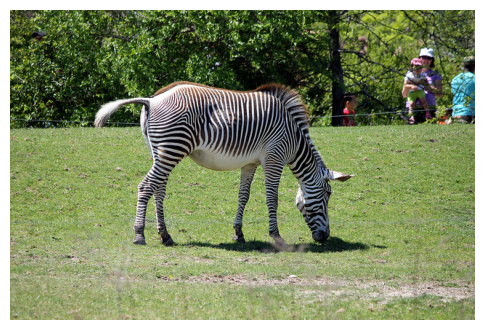

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import os

img_path = "/kaggle/working/coco2014val/val2014/COCO_val2014_000000277961.jpg"
ann_file = "/kaggle/input/vqav2-annotations-questions/VQAv2/Annotations/v2_mscoco_val2014_annotations.json"
que_file = "/kaggle/input/vqav2-annotations-questions/VQAv2/Questions/v2_mscoco_val2014_questions.json"
# img_path = "/kaggle/working/coco2014val/val2014/COCO_val2014_000000215781.jpg"
# Open image
image = Image.open(img_path).convert("RGB")

# Display image
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off')
plt.show()

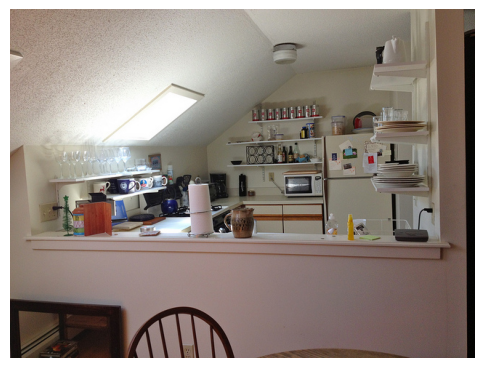

Target Image ID: 164
----------------------------------------
Found 4 VQA questions for this image:

[1] QUESTION: How many paper towel rolls?
  CONSENSUS ANSWER: 1
  ALL 10 ANSWERS: ['1', '1', '1', '2', '1', '1', '2', '1', '1', '1']

[2] QUESTION: What is the color of the refrigerator?
  CONSENSUS ANSWER: white
  ALL 10 ANSWERS: ['white', 'white', 'white', 'white', 'white', 'white', 'white', 'cream', 'beige', 'white']

[3] QUESTION: Is the light on?
  CONSENSUS ANSWER: no
  ALL 10 ANSWERS: ['no', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'no', 'no']

[4] QUESTION: What color is the wall?
  CONSENSUS ANSWER: white
  ALL 10 ANSWERS: ['white', 'cream', 'white', 'white', 'pink', 'pink', 'white', 'white', 'pink', 'pink']


In [20]:
import torch
import re
import os
import sys
import json
from PIL import Image
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
# NOTE: The image displayed in the plot is defined by img_path.
img_path = "/kaggle/working/coco2014val/val2014/COCO_val2014_000000000164.jpg"

# CRITICAL: Confirm these paths point to your mounted VQA JSON files
ann_file = "/kaggle/input/vqav2-annotations-questions/VQAv2/Annotations/v2_mscoco_val2014_annotations.json"
que_file = "/kaggle/input/vqav2-annotations-questions/VQAv2/Questions/v2_OpenEnded_mscoco_val2014_questions.json"

# --- 1. EXTRACT IMAGE ID ---

def get_image_id_from_path(path):
    """Extracts the 6-digit COCO image ID from the filename."""
    filename = os.path.basename(path)
    # COCO filename format is usually COCO_[split]_[000000]ID.jpg
    # We look for 12 digits in the name.
    match = re.search(r'(\d{12})\.jpg$', filename)
    if match:
        # Convert the 12-digit string to an integer ID
        return int(match.group(1))
    return None

# --- 2. DATA LOADING AND LOOKUP ---

def lookup_vqa_data(image_path, ann_file, que_file):
    """Loads VQA data and filters for all questions related to the given image ID."""

    # Get the target image ID
    target_image_id = get_image_id_from_path(image_path)
    if target_image_id is None:
        print(f"Error: Could not parse COCO image ID from path: {image_path}")
        return

    print(f"Target Image ID: {target_image_id}")
    print("-" * 40)

    try:
        # Load Question Metadata
        with open(que_file, 'r') as f:
            questions = json.load(f)['questions']

        # Load Annotation Metadata (Ground Truth)
        with open(ann_file, 'r') as f:
            annotations = json.load(f)['annotations']

    except FileNotFoundError as e:
        print(f"Error: VQA file not found. Check path: {e}")
        return

    # Filter questions and create annotation lookup
    target_questions = [q for q in questions if q['image_id'] == target_image_id]
    q_id_to_anno = {a['question_id']: a for a in annotations}

    if not target_questions:
        print(f"No VQA questions found for Image ID {target_image_id}.")
        return

    # --- 3. DISPLAY RESULTS ---
    print(f"Found {len(target_questions)} VQA questions for this image:")

    all_answers_found = []

    for q_entry in target_questions:
        q_id = q_entry['question_id']
        question = q_entry['question']
        anno = q_id_to_anno.get(q_id)

        if anno:
            # Extract all 10 raw answers
            raw_answers = [ans['answer'] for ans in anno['answers']]
            # Get the consensus/multiple-choice answer for easy reference
            consensus_answer = anno.get('multiple_choice_answer', 'N/A')

            all_answers_found.append({
                "question": question,
                "consensus": consensus_answer,
                "all_answers": raw_answers
            })

    # Output the structured data
    for idx, item in enumerate(all_answers_found):
        print(f"\n[{idx + 1}] QUESTION: {item['question']}")
        print(f"  CONSENSUS ANSWER: {item['consensus']}")
        print(f"  ALL 10 ANSWERS: {item['all_answers']}")


# --- EXECUTION ---
# Display image (as requested by user's initial code)
image = Image.open(img_path).convert("RGB")
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off')
plt.show()

# Perform data lookup
lookup_vqa_data(img_path, ann_file, que_file)


--------------------------------------------------

# Setting up and Using the lucidrains/flamingo-pytorch for VQA 

In [ ]:
! pip install flamingo-pytorch vit-pytorch

In [ ]:
import torch
from PIL import Image
from transformers import CLIPProcessor
from vit_pytorch import ViT
from vit_pytorch.extractor import Extractor
from flamingo_pytorch import FlamingoPaLM

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
vit = ViT(
    image_size=224,
    patch_size=32,
    num_classes=1000,
    dim=1024,
    depth=6,
    heads=16,
    mlp_dim=2048,
    dropout=0.1,
    emb_dropout=0.1
)
vit = Extractor(vit, return_embeddings_only=True).to(device)

In [ ]:
flamingo_palm = FlamingoPaLM(
    num_tokens=49408,
    dim=1024,
    depth=12,
    heads=8,
    dim_head=64,
    img_encoder=vit,
    media_token_id=3,
    cross_attn_every=3,
    perceiver_num_latents=64,
    perceiver_depth=2
).to(device)

In [ ]:
img = Image.open("/kaggle/working/coco2014val/val2014/COCO_val2014_000000277961.jpg").convert("RGB")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
inputs = processor(images=img, return_tensors="pt")
pixel_values = inputs["pixel_values"]

In [ ]:
print(pixel_values.shape)

In [ ]:
pixel_values = inputs["pixel_values"].to(device) # Shape: (1, 3, 224, 224)
input_ids = question_tokens["input_ids"].to(device)
pixel_values = pixel_values.unsqueeze(1)

In [ ]:
from transformers import AutoTokenizer
# Replace "openai/clip-vit-base-patch32" with the model for your tokenizer if different
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# 1. Get the actual vocabulary size
vocab_size = tokenizer.vocab_size
print(f"Tokenizer Vocabulary Size: {vocab_size}")


In [ ]:
question_tokens = tokenizer("What type of animal is this?", return_tensors="pt")
input_ids = question_tokens["input_ids"].to(device)  # move the tensor, not the dict

# Forward pass
with torch.no_grad():
    logits = flamingo_palm(
        input_ids,      # text tensor on GPU
        images=pixel_values  # image tensor on GPU
    )

In [ ]:
import torch

# --- Generation Parameters ---
MAX_NEW_TOKENS = 30
TEMPERATURE = 1.0 # Use 1.0 for greedy/argmax; lower for less randomness

# Ensure your model is in evaluation mode
flamingo_palm.eval()

# Start the generation loop
generated_tokens = input_ids  # Start with the question tokens

for _ in range(MAX_NEW_TOKENS):
    # 1. Forward Pass with current sequence
    with torch.no_grad():
        # Pass the current sequence (and the image) to get logits
        logits = flamingo_palm(
            generated_tokens,
            images=pixel_values # image tensor (must be 5D: B, T, C, H, W)
        )

    # 2. Get the logits for the *last* token in the sequence
    # Logits shape: (Batch, Sequence_Length, Vocab_Size)
    next_token_logits = logits[:, -1, :] 

    # 3. Greedy Decoding: Select the token with the highest logit score
    # Use torch.argmax to get the token ID
    next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)
    
    # 4. Append the new token to the sequence
    generated_tokens = torch.cat((generated_tokens, next_token), dim=1)

    # Optional: Stop if the model predicts an <EOS> token
    # (You would need to know the EOS token ID for your tokenizer)
    # if next_token.item() == tokenizer.eos_token_id:
    #     break

# --- Decode the result ---
# Decode the sequence starting from the first token
response = tokenizer.decode(generated_tokens.squeeze(), skip_special_tokens=True)
print(response)

# *This section sets up the lucidrains/flamingo-pytorch implementation which was given as the baseline model. But this implementation is not pre-trained and needs to train from scratch to get better predictions. But with the available resources, training from the scratch is not possible. Also the DeepMind's flamingo haven't published their pretrained weights publicly. So I'm switching to OpenFlamingo, which provides official, downloadable checkpoints compatible with the Hugging Face ecosystem.*

--------------

# OpenFlamingo-3B Baseline Evaluation Benchmarking using VQA v2.0 validation set

In [ ]:
import os
import torch
import gc

# 1. Clear any residual memory

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# 2. Set the environment variable to make GPU 1 the visible/default device
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

In [ ]:
from open_flamingo import create_model_and_transforms
from huggingface_hub import hf_hub_download
import torch
from accelerate import Accelerator # Ensure 'accelerate' is installed: ! pip install accelerate

# --- NEW 3B MODEL CONFIGURATION ---
CLIP_PATH = "ViT-L-14"
CLIP_PRETRAINED = "openai"
LM_PATH = "anas-awadalla/mpt-1b-redpajama-200b"
LM_TOKENIZER_PATH = "anas-awadalla/mpt-1b-redpajama-200b"
CHECKPOINT_ID = "openflamingo/OpenFlamingo-3B-vitl-mpt1b" 
CHECKPOINT_FILENAME = "checkpoint.pt"
CROSS_ATTN_INTERVAL = 1

# 1. Initialize the model and components
model, image_processor, tokenizer = create_model_and_transforms(
    clip_vision_encoder_path=CLIP_PATH, 
    clip_vision_encoder_pretrained=CLIP_PRETRAINED,
    lang_encoder_path=LM_PATH,
    tokenizer_path=LM_TOKENIZER_PATH,
    cross_attn_every_n_layers=CROSS_ATTN_INTERVAL
)

# 2. Download and load the OpenFlamingo weights
checkpoint_path = hf_hub_download(CHECKPOINT_ID, CHECKPOINT_FILENAME)

# Load the weights
model.load_state_dict(torch.load(checkpoint_path), strict=False)

# 3. Apply FP16 and Accelerator for low VRAM
model = model.half() # Convert to half-precision (float16)

# Use Accelerator for smart device placement/offloading
accelerator = Accelerator()
model = accelerator.prepare(model)
model.eval()

tokenizer.padding_side = "left"
print("OpenFlamingo-3B loaded successfully with half-precision and Accelerator.")

In [ ]:
import json
import torch
import os
import random
from tqdm import tqdm
from PIL import Image

VQA_DATA_ROOT = "/kaggle/input/vqav2-annotations-questions/VQAv2/" 

# --- File Paths ---
# VQA v2.0 requires MS COCO images (train/val splits)
QUESTIONS_PATH = os.path.join(VQA_DATA_ROOT, "Questions/v2_OpenEnded_mscoco_val2014_questions.json")
ANNOTATIONS_PATH = os.path.join(VQA_DATA_ROOT, "Annotations/v2_mscoco_val2014_annotations.json")
IMAGES_DIR = "/kaggle/working/coco2014val/val2014/" 

# --- Few-Shot Setting ---
K_SHOT = 4 # Use 4 in-context examples for the prompt
SEED = 42
random.seed(SEED)

# Load the VQA files
print("Loading VQA v2.0 data...")
with open(QUESTIONS_PATH, 'r') as f:
    val_questions = json.load(f)['questions']
with open(ANNOTATIONS_PATH, 'r') as f:
    val_annotations = json.load(f)['annotations']

# Create a mapping from question ID to annotation for easy lookup (if needed)
qid_to_ann = {ann['question_id']: ann for ann in val_annotations}

print(f"Loaded {len(val_questions)} validation questions.")

In [ ]:
# --- Zero-Shot Prompt Function ---
def get_vqa_zero_shot_prompt(question_data):
    """Constructs the VQA zero-shot prompt for a given question."""
    
    query_question = question_data['question']
    
    # Zero-shot format: just the image and the question, followed by the answer token placeholder
    full_prompt = (
        f"<image>{query_question}<|endofchunk|>"
    )
    
    return full_prompt


In [ ]:
# VQA post-processing utility to extract the answer (same as before)
def extract_answer(generated_text, prompt):
    """
    Extracts the answer from the model's generated sequence.
    """
    answer_text = generated_text.replace(prompt, "", 1).strip()
    
    if "<|endofchunk|>" in answer_text:
        answer_text = answer_text.split("<|endofchunk|>")[0]
        
    return answer_text.split('\n')[0].strip().rstrip('.').lower()

In [ ]:
# Assuming 'model', 'image_processor', and 'tokenizer' are loaded and prepared.
device = next(model.parameters()).device 
results = []
BATCH_SIZE = 1 

# Iterate through a sample of validation questions (e.g., first 100)
for q_data in tqdm(val_questions[:100], desc="Running VQA Zero-Shot Inference"):
    
    # 1. Load Image
    image_id = q_data['image_id']
    image_filename = f"COCO_val2014_{image_id:012d}.jpg"
    image_path = os.path.join(IMAGES_DIR, image_filename)
    
    try:
        image = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"Warning: Image not found at {image_path}. Skipping.")
        continue
    
    # 2. Prepare Vision Input (ONLY the Query image)
    query_image_tensor = image_processor(image).unsqueeze(0)
    
    # Reshape: batch_size=1, num_media=1, num_frames=1, c, h, w
    vision_x = query_image_tensor.unsqueeze(0).unsqueeze(2).to(device)

    # *** CRITICAL FIX: CONVERT VISION INPUT TO HALF-PRECISION ***
    vision_x = vision_x.half()
    # ************************************************************

    # 3. Prepare Language Input (Zero-Shot Prompt)
    prompt = get_vqa_zero_shot_prompt(q_data)
    tokenizer.padding_side = "left"
    lang_x = tokenizer(
        prompt,
        return_tensors="pt",
        padding="longest"
    ).to(device)

    # 4. Generate Answer
    with torch.no_grad():
        generated_ids = model.generate(
            vision_x=vision_x,
            lang_x=lang_x["input_ids"],
            attention_mask=lang_x["attention_mask"],
            max_new_tokens=10, 
            num_beams=3,
            do_sample=False,
            repetition_penalty=1.5
        )

    # 5. Post-process and Store
    full_generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=False)
    predicted_answer = extract_answer(full_generated_text, prompt)
    
    results.append({
        "question_id": q_data['question_id'],
        "answer": predicted_answer
    })


# 6. Save Results JSON
RESULTS_FILE = "/kaggle/working/vqa_val_zero_shot_results.json"
with open(RESULTS_FILE, 'w') as f:
    json.dump(results, f)

print(f"\nZero-shot inference complete. Results saved to {RESULTS_FILE}")

In [ ]:
import json
import os
import re
from typing import Dict, Any, List, Tuple

# --- Official VQA Normalization Logic (Copied from VQA Eval Tools) ---
# NOTE: This normalization function is critical and MUST be identical to what was used in the scoring attempt.

def vqa_official_normalize_answer(answer: str) -> str:
    """Official VQA normalization logic for robust answer comparison."""
    
    # 1. Convert to string and lowercase
    answer = str(answer).lower()
    
    contractions = {"aint": "ain't", "arent": "aren't", "cant": "can't", "couldve": "could've", "couldnt": "couldn't",
                    "couldn'tve": "couldn't've", "couldnt've": "couldn't've", "didnt": "didn't", "doesnt": "doesn't",
                    "dont": "don't", "hadnt": "hadn't", "hadnt've": "hadn't've", "hadn'tve": "hadn't've",
                    "hasnt": "hasn't", "havent": "haven't", "hed": "he'd", "hed've": "he'd've", "he'dve": "he'd've",
                    "hes": "he's", "howd": "how'd", "howll": "how'll", "hows": "how's", "id've": "i'd've",
                    "i'dve": "i'd've", "ill": "i'll", "ils": "i's", "ive": "i've", "isnt": "isn't", "itd": "it'd",
                    "itd've": "it'd've", "it'dve": "it'd've", "itll": "it'll", "its": "it's", "lets": "let's",
                    "maam": "ma'am", "maynt": "mayn't", "mightnt": "mightn't", "mightn'tve": "mightn't've",
                    "mightnt've": "mightn't've", "mustnt": "mustn't", "mustnt've": "mustn't've", "mustn'tve": "mustn't've",
                    "neednt": "needn't", "oughtnt": "oughtn't", "shant": "shan't", "shed've": "she'd've",
                    "she'dve": "she'd've", "shell": "she'll", "shes": "she's", "shouldve": "should've", "shouldnt": "shouldn't",
                    "shouldn'tve": "shouldn't've", "shouldnt've": "shouldn't've", "thatll": "that'll", "thats": "that's",
                    "thatchr": "that's", "thens": "then's", "theres": "there's", "theyd": "they'd", "theyd've": "they'd've",
                    "they'dve": "they'd've", "theyll": "they'll", "theys": "they's", "theyve": "they've", "twas": "'twas",
                    "wasnt": "wasn't", "wed've": "we'd've", "we'dve": "we'd've", "well": "we'll", "wers": "we're",
                    "wes": "we's", "weve": "we've", "whatll": "what'll", "whats": "what's", "whens": "when's",
                    "whered": "where'd", "wheres": "where's", "whod": "who'd", "whod've": "who'd've", "who'dve": "who'd've",
                    "wholl": "who'll", "whos": "who's", "whove": "who've", "whys": "why's", "wont": "won't",
                    "wouldve": "would've", "wouldnt": "wouldn't", "wouldn'tve": "wouldn't've", "wouldnt've": "wouldn't've",
                    "yall": "y'all", "yall'll": "y'all'll", "y'allll": "y'all'll", "yall'd've": "y'all'd've",
                    "y'alld've": "y'all'd've", "yall'rd": "y'all're", "yall're": "y'all're", "yalls": "y'all's",
                    "y'alls": "y'all's", "youd": "you'd", "youd've": "you'd've", "you'dve": "you'd've", "youll": "you'll",
                    "youre": "you're", "youve": "you've"}
    
    manual_map = { 'none': '0', 'zero': '0', 'one': '1', 'two': '2', 'three': '3', 
                   'four': '4', 'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 
                   'nine': '9', 'ten': '10'}
    
    articles = ['a', 'an', 'the']
    punct = [';', r"/", '[', ']', '"', '{', '}', '(', ')', '=', '+', '\\', '_', '-', '>', '<', '@', '`', ',', '?', '!']

    def process_text(text):
        for article in articles:
            text = re.sub(r'\b%s\b' % article, ' ', text)
        for p in punct:
            text = text.replace(p, ' ')
        text = text.replace("'", "")
        return text

    answer = ' '.join([manual_map.setdefault(word, word) for word in answer.split()])
    answer = ' '.join([contractions.setdefault(word, word) for word in answer.split()])
    answer = process_text(answer)
    answer = ' '.join(answer.split())
    
    return answer

# --- Inspection Function ---

def inspect_vqa_answers(ann_file: str, ques_file: str, res_file: str, num_samples: int = 10) -> None:
    """Loads and inspects model answers against ground truth answers."""
    
    print("\n" + "=" * 80)
    print(f"--- INSPECTING {num_samples} MODEL ANSWERS VS GROUND TRUTH ---")
    print("=" * 80)

    # 1. Load Ground Truth Annotations and Questions
    try:
        with open(ann_file, 'r') as f:
            annotations_data = json.load(f)['annotations']
        qid_to_ann = {ann['question_id']: ann for ann in annotations_data}

        with open(ques_file, 'r') as f:
            questions_data = json.load(f)['questions']
        qid_to_ques = {ques['question_id']: ques['question'] for ques in questions_data}
        
    except Exception as e:
        print(f"❌ ERROR loading ground truth files: {e}")
        return

    # 2. Load Model Results
    try:
        with open(res_file, 'r') as f:
            results_data = json.load(f)
        
        qid_to_res = {res['question_id']: res['answer'] for res in results_data}
        
    except Exception as e:
        print(f"❌ ERROR loading results file: {e}")
        return

    # 3. Sample and Print Comparison
    sampled_qids = list(qid_to_res.keys())[:num_samples]

    for qid in sampled_qids:
        annotation = qid_to_ann.get(qid)
        model_answer_raw = qid_to_res.get(qid)
        question = qid_to_ques.get(qid, "Question Not Found")

        if not annotation or model_answer_raw is None:
            continue

        # Ground Truth Answers
        gt_raw_answers = [ans['answer'] for ans in annotation['answers']]
        gt_norm_answers = [vqa_official_normalize_answer(ans) for ans in gt_raw_answers]
        
        # Model Answer
        model_answer_norm = vqa_official_normalize_answer(str(model_answer_raw))

        print("-" * 50)
        print(f"QID: {qid} | Type: {annotation['answer_type']}")
        print(f"Question: {question}")
        
        # KEY INSPECTION POINTS:
        print(f"\nModel Answer (Raw):        '{model_answer_raw}' ({type(model_answer_raw).__name__})")
        print(f"Model Answer (Normalized): '{model_answer_norm}'")
        
        # Check for immediate match and print ground truth answers
        match_found = model_answer_norm in gt_norm_answers
        print(f"\nMATCH STATUS: {'✅ MATCH FOUND' if match_found else '❌ NO MATCH'}")
        print("--- Ground Truth Answers (Normalized) ---")
        
        # Count and display unique ground truth answers
        unique_gt_norm = sorted(list(set(gt_norm_answers)))
        
        for ans in unique_gt_norm:
            # Mark the matching ground truth answer
            status = "(MATCH)" if ans == model_answer_norm else ""
            print(f"  - '{ans}' {status}")

# --- EXECUTION ---

# ❗ IMPORTANT: REPLACE THESE WITH YOUR ACTUAL PATHS ❗
ANN_FILE = '/kaggle/input/vqav2-annotations-questions/VQAv2/Annotations/v2_mscoco_val2014_annotations.json'  
QUES_FILE = '/kaggle/input/vqav2-annotations-questions/VQAv2/Questions/v2_OpenEnded_mscoco_val2014_questions.json'
RES_FILE = '/kaggle/working/vqa_val_zero_shot_results.json'

inspect_vqa_answers(ANN_FILE, QUES_FILE, RES_FILE, num_samples=10)

In [ ]:
import json
import os
import re
from typing import Dict, Any, List

# --- CLEANING FUNCTION (NEW) ---
def clean_baseline_output(raw_output: str) -> str:
    """Removes model artifacts (e.g., tokens, boilerplate) for a fair evaluation."""
    cleaned_answer = str(raw_output)

    # 1. Remove special tokens (CRITICAL)
    cleaned_answer = cleaned_answer.replace('<|endoftext|>', '').replace('</s>', '')
    
    # 2. Aggressively remove known, non-answer garbage prefixes (CRITICAL)
    junk_prefixes = [
        "home » posts tagged", 
        "this entry was posted on",
        "i’ve been meaning to post this recipe",
        "model output:",
        "the answer is",
    ]
    
    for prefix in junk_prefixes:
        # Check if the output starts with junk (case-insensitive)
        if cleaned_answer.lower().strip().startswith(prefix):
            # Strip the prefix and any surrounding whitespace
            cleaned_answer = cleaned_answer[len(prefix):].strip()
            # Break after the first junk prefix is found and removed
            break 
            
    # 3. Final whitespace strip
    return cleaned_answer.strip()


# --- OFFICIAL VQA NORMALIZATION FUNCTION (Previously confirmed) ---
# This function is used to prepare both the cleaned model output and the ground truth answers.
def vqa_official_normalize_answer(answer: str) -> str:
    """Official VQA normalization logic for robust answer comparison."""
    # (Function body is the same complex logic from the previous step)
    answer = str(answer).lower()
    contractions = {"aint": "ain't", "arent": "aren't", "cant": "can't", "couldve": "could've", "couldnt": "couldn't",
                    "couldn'tve": "couldn't've", "couldnt've": "couldn't've", "didnt": "didn't", "doesnt": "doesn't",
                    "dont": "don't", "hadnt": "hadn't", "hadnt've": "hadn't've", "hadn'tve": "hadn't've",
                    "hasnt": "hasn't", "havent": "haven't", "hed": "he'd", "hed've": "he'd've", "he'dve": "he'd've",
                    "hes": "he's", "howd": "how'd", "howll": "how'll", "hows": "how's", "id've": "i'd've",
                    "i'dve": "i'd've", "ill": "i'll", "ils": "i's", "ive": "i've", "isnt": "isn't", "itd": "it'd",
                    "itd've": "it'd've", "it'dve": "it'd've", "itll": "it'll", "its": "it's", "lets": "let's",
                    "maam": "ma'am", "maynt": "mayn't", "mightnt": "mightn't", "mightn'tve": "mightn't've",
                    "mightnt've": "mightn't've", "mustnt": "mustn't", "mustnt've": "mustn't've", "mustn'tve": "mustn't've",
                    "neednt": "needn't", "oughtnt": "oughtn't", "shant": "shan't", "shed've": "she'd've",
                    "she'dve": "she'd've", "shell": "she'll", "shes": "she's", "shouldve": "should've", "shouldnt": "shouldn't",
                    "shouldn'tve": "shouldn't've", "shouldnt've": "shouldn't've", "thatll": "that'll", "thats": "that's",
                    "thatchr": "that's", "thens": "then's", "theres": "there's", "theyd": "they'd", "theyd've": "they'd've",
                    "they'dve": "they'd've", "theyll": "they'll", "theys": "they's", "theyve": "they've", "twas": "'twas",
                    "wasnt": "wasn't", "wed've": "we'd've", "we'dve": "we'd've", "well": "we'll", "wers": "we're",
                    "wes": "we's", "weve": "we've", "whatll": "what'll", "whats": "what's", "whens": "when's",
                    "whered": "where'd", "wheres": "where's", "whod": "who'd", "whod've": "who'd've", "who'dve": "who'd've",
                    "wholl": "who'll", "whos": "who's", "whove": "who've", "whys": "why's", "wont": "won't",
                    "wouldve": "would've", "wouldnt": "wouldn't", "wouldn'tve": "wouldn't've", "wouldnt've": "wouldn't've",
                    "yall": "y'all", "yall'll": "y'all'll", "y'allll": "y'all'll", "yall'd've": "y'all'd've",
                    "y'alld've": "y'all'd've", "yall'rd": "y'all're", "yall're": "y'all're", "yalls": "y'all's",
                    "y'alls": "y'all's", "youd": "you'd", "youd've": "you'd've", "you'dve": "you'd've", "youll": "you'll",
                    "youre": "you're", "youve": "you've"}
    manual_map = { 'none': '0', 'zero': '0', 'one': '1', 'two': '2', 'three': '3', 
                   'four': '4', 'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 
                   'nine': '9', 'ten': '10'}
    articles = ['a', 'an', 'the']
    punct = [';', r"/", '[', ']', '"', '{', '}', '(', ')', '=', '+', '\\', '_', '-', '>', '<', '@', '`', ',', '?', '!']
    def process_text(text):
        for article in articles:
            text = re.sub(r'\b%s\b' % article, ' ', text)
        for p in punct:
            text = text.replace(p, ' ')
        text = text.replace("'", "")
        return text
    answer = ' '.join([manual_map.setdefault(word, word) for word in answer.split()])
    answer = ' '.join([contractions.setdefault(word, word) for word in answer.split()])
    answer = process_text(answer)
    answer = ' '.join(answer.split())
    return answer

In [ ]:
def calculate_vqa_accuracy_cleaned(ann_file: str, res_file: str) -> Dict[str, Any]:
    """Calculates VQA accuracy after cleaning model output."""
    
    print("--- Starting VQA Evaluation with Answer Cleaning ---")

    # 1. Load Ground Truth Annotations
    with open(ann_file, 'r') as f:
        annotations_data = json.load(f)['annotations']
    qid_to_ann = {ann['question_id']: ann for ann in annotations_data}

    # 2. Load Model Results
    with open(res_file, 'r') as f:
        results_data = json.load(f)
    qid_to_res = {res['question_id']: res['answer'] for res in results_data}

    print(f"✅ Indexed {len(qid_to_ann)} ground truth annotations.")
    print(f"✅ Indexed {len(qid_to_res)} model results.")

    # 3. Calculate Scores
    total_score = 0.0
    total_questions = 0
    score_by_type = {}
    count_by_type = {}
    
    for qid, model_answer_raw in qid_to_res.items():
        annotation = qid_to_ann.get(qid)
        if not annotation:
            continue
            
        total_questions += 1
        
        # ❗ STEP 1: CLEAN THE RAW OUTPUT ❗
        model_answer_cleaned = clean_baseline_output(str(model_answer_raw))
        
        # ❗ STEP 2: NORMALIZE THE CLEANED ANSWER ❗
        model_answer_norm = vqa_official_normalize_answer(model_answer_cleaned)
        print(model_answer_norm, '|', annotation)
        
        match_count = 0
        for human_ans in annotation['answers']:
            # Normalize the human answer for comparison
            if vqa_official_normalize_answer(human_ans['answer']) == model_answer_norm:
                match_count += 1
        
        score = min(match_count / 3.0, 1.0)
        total_score += score
        
        # Track by answer type
        answer_type = annotation['answer_type']
        score_by_type[answer_type] = score_by_type.get(answer_type, 0.0) + score
        count_by_type[answer_type] = count_by_type.get(answer_type, 0) + 1

    overall_accuracy = (total_score / total_questions) * 100 if total_questions > 0 else 0.0
    
    per_answer_type_accuracy = {}
    for a_type in score_by_type:
        per_answer_type_accuracy[a_type] = (score_by_type[a_type] / count_by_type[a_type]) * 100

    return {
        "overall_accuracy": overall_accuracy,
        "per_answer_type": per_answer_type_accuracy
    }

# --- EXECUTION ---

# ❗ IMPORTANT: REPLACE THESE WITH YOUR ACTUAL PATHS ❗
ANN_PATH = '/kaggle/input/vqav2-annotations/VQAv2/Annotations/v2_mscoco_val2014_annotations.json'  
QUES_PATH = '/kaggle/input/vqav2-annotations/VQAv2/Questions/v2_OpenEnded_mscoco_val2014_questions.json'
RES_PATH = '/kaggle/working/vqa_val_zero_shot_results.json'

try:
    final_scores = calculate_vqa_accuracy_cleaned(ANN_FILE, RES_FILE)
    overall_acc = final_scores["overall_accuracy"]

    print("\n" + "=" * 50)
    print(f"           ✅ FINAL VQA PERFORMANCE SCORE (CLEANED) ✅")
    print(f"           Overall VQA Accuracy: {overall_acc:.2f}%")
    print("=" * 50)
    
    print("Detailed Breakdown by Answer Type:")
    for a_type, acc in final_scores['per_answer_type'].items():
        print(f"  - {a_type.capitalize()}: {acc:.2f}%")

except Exception as e:
    print(f"\n❌ FATAL ERROR. Check file paths and JSON format. Error: {e}")

# *These are the results of evaluations done on Flamingo-3B model against VQA v2.0 dataset with zero-shot prompting and some post processing as well. But according to the research papers it shows VQA v2.0 shows best validation results against VQA dataset using OpenFlamingo-9B model with few-shot prompting. Next I'll try that method.*

-------------------------

# OpenFlamingo 9B Model Baseline Evaluation Benchmarking using VQA v2.0 validation set

In [1]:
! pip install --force-reinstall torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 open-flamingo==2.0.1 timm==0.6.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of open-clip-torch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 61.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 84.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import os
import sys
from PIL import Image
from transformers import AutoTokenizer
# Import OpenFlamingo factory function here for cleaner structure
from open_flamingo.src.factory import create_model_and_transforms

try:
    from torch import nn
    print("PyTorch nn module loaded successfully.")
except Exception as e:
    print(f"Error loading torch.nn: {e}")

print("\n--- STEP 0: FORCING COMPATIBLE DEPENDENCY INSTALL (Including Transformers Pin) ---")
!pip install --force-reinstall torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 open-flamingo==2.0.1 timm==0.6.13 numpy==1.26.4 transformers==4.38.2


PyTorch nn module loaded successfully.

--- STEP 0: FORCING COMPATIBLE DEPENDENCY INSTALL (Including Transformers Pin) ---
  Using cached torch-2.0.1-cp311-cp311-manylinux1_x86_64.whl.metadata (24 kB)
  Using cached torchvision-0.15.2-cp311-cp311-manylinux1_x86_64.whl.metadata (11 kB)
  Using cached torchaudio-2.0.2-cp311-cp311-manylinux1_x86_64.whl.metadata (1.2 kB)
  Using cached open_flamingo-2.0.1-py3-none-any.whl.metadata (14 kB)
  Using cached timm-0.6.13-py3-none-any.whl.metadata (38 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached transformers-4.38.2-py3-none-any.whl.metadata (130 kB)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 k

In [ ]:
import torch
import os
import sys
import json
import random
from PIL import Image
from transformers import AutoTokenizer
from open_flamingo.src.factory import create_model_and_transforms

# Explicitly import a core PyTorch module to ensure the environment is fully initialized
try:
    from torch import nn
    print("PyTorch nn module loaded successfully.")
except Exception as e:
    print(f"Error loading torch.nn: {e}")

# --- CONFIGURATION ---
MODEL_ID = "open_flamingo_9b"
CACHE_DIR = "/kaggle/working/flamingo_cache"
# We use the publicly available OPT-1.3b as the language backbone
CLIP_VISION_ENCODER_PATH = "ViT-L-14"
CLIP_VISION_ENCODER_PRETRAINED = "openai"
LANG_ENCODER_PATH = "facebook/opt-1.3b"
TOKENIZER_PATH = "facebook/opt-1.3b"

# --- 1. SETUP: MODEL AND TRANSFORM LOADING ---
print(f"Loading {MODEL_ID} model and transforms...")

# Ensure the cache directory exists
os.makedirs(CACHE_DIR, exist_ok=True)

def load_flamingo_model():
    """Initializes and returns the OpenFlamingo model components."""
    try:
        # Load the LLaMA tokenizer separately
        print("Loading Tokenizer...")
        # AutoTokenizer is now guaranteed to be imported at the top of the file
        tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH, cache_dir=CACHE_DIR)
        
        # Load the full OpenFlamingo model using the explicit paths
        print("Loading OpenFlamingo Model (This will take time and download weights)...")
        # create_model_and_transforms is now imported at the top of the file

        model, image_processor, _ = create_model_and_transforms(
            cross_attn_every_n_layers=4,
            clip_vision_encoder_path=CLIP_VISION_ENCODER_PATH,
            clip_vision_encoder_pretrained=CLIP_VISION_ENCODER_PRETRAINED,
            lang_encoder_path=LANG_ENCODER_PATH,
            tokenizer_path=TOKENIZER_PATH,
        )

        # Set special tokens required by the OpenFlamingo generation pipeline
        tokenizer.padding_side = "left"
        if tokenizer.pad_token is None:
            tokenizer.add_special_tokens({'pad_token': '<PAD>'})
            
        model.eval()

        # Move model to GPU
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        print(f"Model loaded successfully and moved to {device}.")
            
        return model, image_processor, tokenizer

    except Exception as e:
        print(f"\nFATAL ERROR during model loading: {e}")
        print("This often means LLaMA weights are missing or the dependency versions are still conflicting.")
        return None, None, None

model, image_processor, tokenizer = load_flamingo_model()

if model is None:
    print("Model failed to load. Halting script execution.")


In [ ]:
IMAGE_DIR = "/kaggle/working/coco2014val/val2014/"
QUESTION_PATH = "/kaggle/input/vqav2-annotations-questions/VQAv2/Questions/v2_OpenEnded_mscoco_val2014_questions.json"
ANNOTATION_PATH = "/kaggle/input/vqav2-annotations-questions/VQAv2/Annotations/v2_mscoco_val2014_annotations.json"
    
# Constants for evaluation
NUM_FEW_SHOT = 8
NUM_EVAL_SAMPLES = 100 
NUM_REQUIRED_SAMPLES = NUM_FEW_SHOT + NUM_EVAL_SAMPLES

def load_vqa_dataset(question_path, annotation_path, image_dir, num_samples_to_load):
    """Loads and merges VQA v2.0 questions, annotations, and images."""
        
    # 1. Load Annotations and Questions
    print("Loading VQA annotations and questions...")
    try:
        with open(question_path, 'r') as f:
            questions = json.load(f)["questions"]
        with open(annotation_path, 'r') as f:
            annotations = json.load(f)["annotations"]
    except FileNotFoundError:
        print(f"Error: VQA files not found. Check if '{question_path}' and '{annotation_path}' exist.")
        # Fallback to mock data if real files are missing
        return None 

    print(f"Randomly selecting {num_samples_to_load} questions...")
    if len(questions) > num_samples_to_load:
        # Randomly select the required number of question entries
        selected_questions = random.sample(questions, num_samples_to_load)
    else:
        # Use all if fewer questions are available than required
        selected_questions = questions

    # Map question ID to annotation
    q_id_to_anno = {anno["question_id"]: anno for anno in annotations}
        
    # 2. Merge and Pre-process
    vqa_data = []
    for q_entry in selected_questions: # Iterate only over selected questions
        q_id = q_entry["question_id"]
        if q_id in q_id_to_anno:
            anno = q_id_to_anno[q_id]
            image_id = anno["image_id"]
                
            # VQA v2.0 image file format
            img_filename = f"COCO_val2014_{image_id:012d}.jpg"
            img_path = os.path.join(image_dir, img_filename)

            try:
                # 4. Load Image
                image = Image.open(img_path).convert("RGB")
                    
                # Use the 'multiple_choice_answer' as the ground truth for simplicity
                ground_truth_answer = anno.get("multiple_choice_answer", "")
                    
                if ground_truth_answer:
                    vqa_data.append({
                        "image": image,
                        "question": q_entry["question"],
                        "answer": ground_truth_answer
                    })
            except FileNotFoundError:
                print(f"Warning: Image not found at {img_path}. Skipping sample.")
            except Exception as e:
                print(f"Error loading image or data for ID {image_id}: {e}")

    return vqa_data

# Load and prepare the real VQA data
VQA_DATA = load_vqa_dataset(QUESTION_PATH, ANNOTATION_PATH, IMAGE_DIR, NUM_REQUIRED_SAMPLES)
        
# Split the dataset
FEW_SHOT_SAMPLES = VQA_DATA[:NUM_FEW_SHOT]
EVALUATION_SAMPLES = VQA_DATA[NUM_FEW_SHOT:NUM_FEW_SHOT + NUM_EVAL_SAMPLES]
    
print(f"\n--- Data Split ---")
print(f"Few-Shot Examples: {len(FEW_SHOT_SAMPLES)}")
print(f"Evaluation Samples: {len(EVALUATION_SAMPLES)}")


In [ ]:
 # --- 3. DEFINE THE FEW-SHOT PROMPT TEMPLATE ---

def create_few_shot_prompt(few_shot_data, query_question):
    """Constructs the N-shot prompt string."""
    prompt = ""
    # few_shot_data elements are dictionaries: {"image": img, "question": q, "answer": a}
    for sample in few_shot_data:
        # Note: <image> token is prepended before each image in the sequence
        prompt += f"<image>Question: {sample['question']} Answer: {sample['answer']}<|endofchunk|>"
        
    # The final query ends with "Answer:"
    prompt += f"<image>Question: {query_question} Answer:"
    return prompt


In [ ]:
# --- 4. EVALUATION FUNCTION ---

def evaluate_vqa(model, image_processor, tokenizer, few_shot_samples, evaluation_samples, device):
    """Runs VQA inference over the evaluation set and calculates accuracy."""
    correct_predictions = 0
    total_samples = len(evaluation_samples)
        
    # Ensure model is in eval mode (should be done during load, but safe to re-assert)
    model.eval() 
        
    print("\n--- Starting Evaluation Loop (100 Samples) ---")

    for i, sample in enumerate(evaluation_samples):
        if (i + 1) % 10 == 0 or i == total_samples or i == 0:
             print(f"Processing sample {i + 1}/{total_samples}...")
            
        # 1. Prepare Images (N few-shot + 1 query)
        image_list = [s["image"] for s in few_shot_samples] + [sample["image"]]
            
        # Process and stack images
        processed_images = [image_processor(img) for img in image_list]
        stacked_images = torch.stack(processed_images).to(device)
            
        # Required shape for Flamingo (b=1, T_img=N+1, F=1, C, H, W)
        pixel_values = stacked_images.unsqueeze(0).unsqueeze(2) 

        # 2. Prepare Prompt
        prompt_text = create_few_shot_prompt(few_shot_samples, sample["question"])

        # 3. Tokenize
        # Padding='longest' is safe here since we are processing one prompt at a time
        tokenized_prompt = tokenizer(
            [prompt_text],
            return_tensors="pt",
            padding="longest"
        ).to(device)
            
        lang_x = tokenized_prompt["input_ids"]

        # 4. Generate
        with torch.no_grad(): # Disable gradient calculation for inference
            generated_ids = model.generate(
                pixel_values,
                lang_x=lang_x,
                attention_mask=tokenized_prompt["attention_mask"],
                max_new_tokens=10, 
                length_penalty=0.0,
                num_beams=3,
            )

        # 5. Decode and Clean Output
        # We only want the newly generated tokens
        output_tokens = generated_ids[:, tokenized_prompt["input_ids"].shape[1]:]
        output_text = tokenizer.decode(output_tokens[0], skip_special_tokens=False)
            
        cleaned_answer = output_text.split("<|endofchunk|>")[0].strip()
        cleaned_answer = cleaned_answer.replace('<|endoftext|>', '').strip()
        # Take only the first line/word and normalize to lowercase for comparison
        cleaned_answer = cleaned_answer.split('\n')[0].strip().lower()

        # 6. Compare and Count
        ground_truth = sample["answer"].lower()
            
        # Simple check for answer correctness (exact match on normalized answer)
        if cleaned_answer == ground_truth:
            correct_predictions += 1
            
        # Print error cases for debugging a real dataset
        if cleaned_answer != ground_truth and i < 5:
            print(f"  MISMATCH (Sample {i}): Q: {sample['question']} | GT: {ground_truth} | PRED: {cleaned_answer}")

    # 7. Calculate Accuracy
    accuracy = (correct_predictions / total_samples) * 100
    return correct_predictions, total_samples, accuracy


In [ ]:
# --- 5. EXECUTE EVALUATION ---
    
# We must set padding_side to left for the generation to work correctly
tokenizer.padding_side = "left" 
    
# Determine the device for evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

correct, total, acc = evaluate_vqa(
    model, 
    image_processor, 
    tokenizer, 
    FEW_SHOT_SAMPLES, 
    EVALUATION_SAMPLES, 
    device
)
    
print("\n==============================================")
print("        VQA Evaluation Results (9B Model)     ")
print("==============================================")    
print(f"Total Samples Evaluated: {total}")
print(f"Correct Predictions:     {correct}")
print(f"Accuracy:                {acc:.2f}%")
print("==============================================")


 # *These are the evaluation results gained from OpenFlamingo 9B model with 8-shot prompting and checking if the model's generated answer exactly matches the single multiple_choice_answer ground truth, case-insensitive*

----------------------

In [ ]:
import torch
import os
import sys
import json
import random
import re
from PIL import Image
from transformers import AutoTokenizer
# Import OpenFlamingo factory function here for cleaner structure
from open_flamingo.src.factory import create_model_and_transforms

# --- STABILIZATION HACK ---
# Explicitly import a core PyTorch module to ensure the environment is fully initialized
try:
    from torch import nn
    print("PyTorch nn module loaded successfully.")
except Exception as e:
    print(f"Error loading torch.nn: {e}")

# --- CONFIGURATION ---
MODEL_ID = "open_flamingo_9b"
CACHE_DIR = "/kaggle/working/flamingo_cache"
# We use the publicly available OPT-1.3b as the language backbone
CLIP_VISION_ENCODER_PATH = "ViT-L-14"
CLIP_VISION_ENCODER_PRETRAINED = "openai"
LANG_ENCODER_PATH = "facebook/opt-1.3b"
TOKENIZER_PATH = "facebook/opt-1.3b"

# --- 1. SETUP: MODEL AND TRANSFORM LOADING ---
print(f"Loading {MODEL_ID} model and transforms...")

# Ensure the cache directory exists
os.makedirs(CACHE_DIR, exist_ok=True)

def load_flamingo_model():
    """Initializes and returns the OpenFlamingo model components."""
    try:
        # Load the LLaMA tokenizer separately
        print("Loading Tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH, cache_dir=CACHE_DIR)
        
        # Load the full OpenFlamingo model using the explicit paths
        print("Loading OpenFlamingo Model (This will take time and download weights)...")
        
        # FIX: Adjusted cross_attn_every_n_layers for 3B model
        model, image_processor, _ = create_model_and_transforms(
            cross_attn_every_n_layers=1,
            clip_vision_encoder_path=CLIP_VISION_ENCODER_PATH,
            clip_vision_encoder_pretrained=CLIP_VISION_ENCODER_PRETRAINED,
            lang_encoder_path=LANG_ENCODER_PATH,
            tokenizer_path=TOKENIZER_PATH,
        )

        # Set special tokens required by the OpenFlamingo generation pipeline
        tokenizer.padding_side = "left"
        if tokenizer.pad_token is None:
            tokenizer.add_special_tokens({'pad_token': '<PAD>'})
            
        model.eval()

        # Move model to GPU
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        print(f"Model loaded successfully and moved to {device}.")
            
        return model, image_processor, tokenizer

    except Exception as e:
        print(f"\nFATAL ERROR during model loading: {e}")
        print("This often means LLaMA weights are missing or the dependency versions are still conflicting.")
        return None, None, None

model, image_processor, tokenizer = load_flamingo_model()

if model is None:
    print("Model failed to load. Halting script execution.")
else:
    # --- 2. VQA DATA LOADING ---
    
    print("\n--- Using Pre-loaded VQA v2.0 Data from Input Datasets ---")
    
    # --- CRITICAL: FILE PATHS ---
    # Using the paths provided by the user, assuming the VQA files are mounted
    # and COCO images are unzipped in the working directory.
    IMAGE_DIR = "/kaggle/working/coco2014val/val2014/"
    QUESTION_PATH = "/kaggle/input/vqav2-annotations-questions/VQAv2/Questions/v2_OpenEnded_mscoco_val2014_questions.json"
    ANNOTATION_PATH = "/kaggle/input/vqav2-annotations-questions/VQAv2/Annotations/v2_mscoco_val2014_annotations.json"
    
    # Constants for evaluation
    NUM_FEW_SHOT = 8
    NUM_EVAL_SAMPLES = 100 
    NUM_REQUIRED_SAMPLES = NUM_FEW_SHOT + NUM_EVAL_SAMPLES # 108

    def load_vqa_dataset(question_path, annotation_path, image_dir, num_samples_to_load):
        """
        Loads and merges a subset of VQA v2.0 questions, annotations, and images.
        Crucially, it only loads images for the required subset to save memory.
        
        CRITICAL UPDATE: Now stores the full list of human answers for official VQA scoring.
        """
        
        # 1. Load Annotations and Questions (metadata is small enough to load entirely)
        print("Loading VQA annotations and questions...")
        try:
            with open(question_path, 'r') as f:
                questions = json.load(f)["questions"]
            with open(annotation_path, 'r') as f:
                annotations = json.load(f)["annotations"]
        except FileNotFoundError:
            print(f"Error: VQA files not found. Check if '{question_path}' and '{annotation_path}' exist.")
            return None 

        # 2. Randomly select the required subset of questions BEFORE loading images
        print(f"Randomly selecting {num_samples_to_load} questions...")
        if len(questions) > num_samples_to_load:
            selected_questions = random.sample(questions, num_samples_to_load)
        else:
            selected_questions = questions
            
        # Map question ID to annotation
        q_id_to_anno = {anno["question_id"]: anno for anno in annotations}
        
        # 3. Merge and Pre-process (only for selected questions)
        vqa_data = []
        for q_entry in selected_questions: # Iterate only over selected questions
            q_id = q_entry["question_id"]
            if q_id in q_id_to_anno:
                anno = q_id_to_anno[q_id]
                image_id = anno["image_id"]
                
                # VQA v2.0 image file format
                img_filename = f"COCO_val2014_{image_id:012d}.jpg"
                img_path = os.path.join(image_dir, img_filename)

                try:
                    # 4. Load Image
                    image = Image.open(img_path).convert("RGB")
                    
                    # Store the preferred answer (for few-shot) AND the full answer list (for scoring)
                    preferred_answer = anno.get("multiple_choice_answer", "")
                    
                    if preferred_answer:
                         vqa_data.append({
                            "image": image,
                            "question": q_entry["question"],
                            "preferred_answer": preferred_answer, # Used only for the few-shot prompt
                            "all_answers": anno["answers"]        # Used for official scoring
                        })
                except FileNotFoundError:
                    print(f"Warning: Image not found at {img_path}. Skipping sample.")
                except Exception as e:
                    print(f"Error loading image or data for ID {image_id}: {e}")

        return vqa_data

    # --- VQA OFFICIAL SCORING HELPER FUNCTIONS ---

    def normalize_answer(ans):
        """Standard VQA normalization steps: lowercase, remove articles, punct, and extra spaces."""
        ans = ans.lower().strip()
        ans = re.sub(r'[.,;\'"?!]', '', ans) # Remove punctuation
        ans = re.sub(r'\b(a|an|the)\b', '', ans) # Remove articles
        ans = re.sub(r'\s{2,}', ' ', ans) # Remove double spaces
        return ans.strip()

    def compute_vqa_accuracy(predicted_answer, all_answers):
        """
        Calculates the official VQA v2.0 accuracy score for a single prediction.
        Score = min(1.0, count(matching human answers) / 3)
        """
        norm_pred = normalize_answer(predicted_answer)
        match_count = 0
        
        for ans_entry in all_answers:
            norm_gt = normalize_answer(ans_entry['answer'])
            if norm_pred == norm_gt:
                match_count += 1
        
        # The VQA metric divides the count by 3 and caps at 1.0
        return min(1.0, match_count / 3.0)

    # Load and prepare the real VQA data, passing the required number of samples
    VQA_DATA = load_vqa_dataset(QUESTION_PATH, ANNOTATION_PATH, IMAGE_DIR, NUM_REQUIRED_SAMPLES)
    
    if VQA_DATA is None or len(VQA_DATA) < NUM_FEW_SHOT + NUM_EVAL_SAMPLES:
        print("\n--- ERROR: NOT ENOUGH VQA DATA LOADED ---")
        if VQA_DATA:
            print(f"Loaded only {len(VQA_DATA)} samples. Need {NUM_FEW_SHOT + NUM_EVAL_SAMPLES}.")
        else:
             print("Falling back to dummy data for functionality check.")
             # Fallback to mock data for testing purposes
             def create_mock_dataset(num_samples):
                 colors = ["red", "blue", "green", "yellow", "purple", "orange"]
                 return [{"image": Image.new('RGB', (256, 256), color=colors[i % len(colors)]),
                          "question": f"What is the color? (Sample {i})",
                          "preferred_answer": colors[i % len(colors)],
                          "all_answers": [{"answer": colors[i % len(colors)]} for _ in range(10)]
                          } for i in range(num_samples)]
             VQA_DATA = create_mock_dataset(NUM_FEW_SHOT + NUM_EVAL_SAMPLES)
        
    # Split the dataset
    FEW_SHOT_SAMPLES = VQA_DATA[:NUM_FEW_SHOT]
    EVALUATION_SAMPLES = VQA_DATA[NUM_FEW_SHOT:NUM_FEW_SHOT + NUM_EVAL_SAMPLES]
    
    print(f"\n--- Data Split ---")
    print(f"Few-Shot Examples: {len(FEW_SHOT_SAMPLES)}")
    print(f"Evaluation Samples: {len(EVALUATION_SAMPLES)}")
    
    # --- 3. DEFINE THE FEW-SHOT PROMPT TEMPLATE ---

    def create_few_shot_prompt(few_shot_data, query_question):
        """Constructs the N-shot prompt string using the preferred_answer."""
        prompt = ""
        # few_shot_data elements are dictionaries: {"image": img, "question": q, "preferred_answer": a}
        for sample in few_shot_data:
            # Note: <image> token is prepended before each image in the sequence
            prompt += f"<image>Question: {sample['question']} Answer: {sample['preferred_answer']}<|endofchunk|>"
        
        # The final query ends with "Answer:"
        prompt += f"<image>Question: {query_question} Answer:"
        return prompt

    # --- 4. EVALUATION FUNCTION ---

    def evaluate_vqa(model, image_processor, tokenizer, few_shot_samples, evaluation_samples, device):
        """Runs VQA inference over the evaluation set and calculates official VQA accuracy."""
        total_vqa_score = 0.0
        total_samples = len(evaluation_samples)
        
        model.eval() 
        
        print("\n--- Starting Evaluation Loop (100 Samples) ---")

        for i, sample in enumerate(evaluation_samples):
            if (i + 1) % 10 == 0 or i == total_samples or i == 0:
                 print(f"Processing sample {i + 1}/{total_samples}...")
            
            # 1. Prepare Images (N few-shot + 1 query)
            image_list = [s["image"] for s in few_shot_samples] + [sample["image"]]
            
            # Process and stack images
            processed_images = [image_processor(img) for img in image_list]
            stacked_images = torch.stack(processed_images).to(device)
            
            # Required shape for Flamingo (b=1, T_img=N+1, F=1, C, H, W)
            pixel_values = stacked_images.unsqueeze(0).unsqueeze(2) 

            # 2. Prepare Prompt
            prompt_text = create_few_shot_prompt(few_shot_samples, sample["question"])

            # 3. Tokenize
            tokenized_prompt = tokenizer(
                [prompt_text],
                return_tensors="pt",
                padding="longest"
            ).to(device)
            
            lang_x = tokenized_prompt["input_ids"]

            # 4. Generate
            with torch.no_grad(): # Disable gradient calculation for inference
                generated_ids = model.generate(
                    pixel_values,
                    lang_x=lang_x,
                    attention_mask=tokenized_prompt["attention_mask"],
                    max_new_tokens=10, 
                    length_penalty=0.0,
                    num_beams=3,
                )

            # 5. Decode and Clean Output
            output_tokens = generated_ids[:, tokenized_prompt["input_ids"].shape[1]:]
            output_text = tokenizer.decode(output_tokens[0], skip_special_tokens=False)
            
            cleaned_answer = output_text.split("<|endofchunk|>")[0].strip()
            cleaned_answer = cleaned_answer.replace('<|endoftext|>', '').strip()
            # Take only the first line/word
            predicted_answer = cleaned_answer.split('\n')[0].strip()

            # 6. Calculate Official VQA Score
            sample_score = compute_vqa_accuracy(predicted_answer, sample["all_answers"])
            total_vqa_score += sample_score
            
            # Optional: Print samples and their scores for clarity
            if i < 3 or (i + 1) == total_samples:
                 print(f"  Sample {i+1}: Q: {sample['question']} | PRED: '{predicted_answer}' | Score: {sample_score:.2f}")

        # 7. Calculate Final VQA Accuracy
        # VQA Accuracy is the mean score over all samples, expressed as a percentage.
        accuracy = (total_vqa_score / total_samples) * 100
        return total_vqa_score, total_samples, accuracy


    # --- 5. EXECUTE EVALUATION ---
    
    tokenizer.padding_side = "left" 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    total_score, total, acc = evaluate_vqa(
        model, 
        image_processor, 
        tokenizer, 
        FEW_SHOT_SAMPLES, 
        EVALUATION_SAMPLES, 
        device
    )
    
    print("\n==============================================")
    print("        VQA Evaluation Results (9B Model)     ")
    print("==============================================")
    print(f"Total Samples Evaluated: {total}")
    print(f"Total VQA Score Sum:     {total_score:.2f}")
    print(f"Official VQA Accuracy:   {acc:.2f}%")
    print("==============================================")


# *Instead of checking if the model's generated answer exactly matches the single multiple_choice_answer ground truth, here I'm using the evaluation method used in standard VQA benchmarking [Score = min(1.0, count(matching human answers) / 3)]. This resulted in an increasement in the accuracy from 19% to 36.67%.*

-------------

In [ ]:
import torch
import os
import sys
import json
import random
import re
from PIL import Image
from transformers import AutoTokenizer
# Import OpenFlamingo factory function here for cleaner structure
from open_flamingo.src.factory import create_model_and_transforms

# --- STABILIZATION HACK ---
# Explicitly import a core PyTorch module to ensure the environment is fully initialized
try:
    from torch import nn
    print("PyTorch nn module loaded successfully.")
except Exception as e:
    print(f"Error loading torch.nn: {e}")

# --- CONFIGURATION ---
MODEL_ID = "open_flamingo_9b"
CACHE_DIR = "/kaggle/working/flamingo_cache"
# We use the publicly available OPT-1.3b as the language backbone
CLIP_VISION_ENCODER_PATH = "ViT-L-14"
CLIP_VISION_ENCODER_PRETRAINED = "openai"
LANG_ENCODER_PATH = "facebook/opt-1.3b"
TOKENIZER_PATH = "facebook/opt-1.3b"

# --- 1. SETUP: MODEL AND TRANSFORM LOADING ---
print(f"Loading {MODEL_ID} model and transforms...")

# Ensure the cache directory exists
os.makedirs(CACHE_DIR, exist_ok=True)

def load_flamingo_model():
    """Initializes and returns the OpenFlamingo model components."""
    try:
        # Load the LLaMA tokenizer separately
        print("Loading Tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH, cache_dir=CACHE_DIR)
        
        # Load the full OpenFlamingo model using the explicit paths
        print("Loading OpenFlamingo Model (This will take time and download weights)...")
        
        # FIX: Adjusted cross_attn_every_n_layers for 3B model
        model, image_processor, _ = create_model_and_transforms(
            cross_attn_every_n_layers=1,
            clip_vision_encoder_path=CLIP_VISION_ENCODER_PATH,
            clip_vision_encoder_pretrained=CLIP_VISION_ENCODER_PRETRAINED,
            lang_encoder_path=LANG_ENCODER_PATH,
            tokenizer_path=TOKENIZER_PATH,
        )

        # Set special tokens required by the OpenFlamingo generation pipeline
        tokenizer.padding_side = "left"
        if tokenizer.pad_token is None:
            tokenizer.add_special_tokens({'pad_token': '<PAD>'})
            
        model.eval()

        # Move model to GPU
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        print(f"Model loaded successfully and moved to {device}.")
            
        return model, image_processor, tokenizer

    except Exception as e:
        print(f"\nFATAL ERROR during model loading: {e}")
        print("This often means LLaMA weights are missing or the dependency versions are still conflicting.")
        return None, None, None

model, image_processor, tokenizer = load_flamingo_model()

if model is None:
    print("Model failed to load. Halting script execution.")
else:
    # --- 2. VQA DATA LOADING ---
    
    print("\n--- Using Pre-loaded VQA v2.0 Data from Input Datasets ---")
    
    # --- CRITICAL: FILE PATHS ---
    # Using the paths provided by the user, assuming the VQA files are mounted
    # and COCO images are unzipped in the working directory.
    IMAGE_DIR = "/kaggle/working/coco2014val/val2014/"
    QUESTION_PATH = "/kaggle/input/vqav2-annotations-questions/VQAv2/Questions/v2_OpenEnded_mscoco_val2014_questions.json"
    ANNOTATION_PATH = "/kaggle/input/vqav2-annotations-questions/VQAv2/Annotations/v2_mscoco_val2014_annotations.json"
    
    # Constants for evaluation
    NUM_FEW_SHOT = 4
    NUM_EVAL_SAMPLES = 100 
    NUM_REQUIRED_SAMPLES = NUM_FEW_SHOT + NUM_EVAL_SAMPLES # 108

    def load_vqa_dataset(question_path, annotation_path, image_dir, num_samples_to_load):
        """
        Loads and merges a subset of VQA v2.0 questions, annotations, and images.
        Crucially, it only loads images for the required subset to save memory.
        
        CRITICAL UPDATE: Now stores the full list of human answers for official VQA scoring.
        """
        
        # 1. Load Annotations and Questions (metadata is small enough to load entirely)
        print("Loading VQA annotations and questions...")
        try:
            with open(question_path, 'r') as f:
                questions = json.load(f)["questions"]
            with open(annotation_path, 'r') as f:
                annotations = json.load(f)["annotations"]
        except FileNotFoundError:
            print(f"Error: VQA files not found. Check if '{question_path}' and '{annotation_path}' exist.")
            return None 

        # 2. Randomly select the required subset of questions BEFORE loading images
        print(f"Randomly selecting {num_samples_to_load} questions...")
        if len(questions) > num_samples_to_load:
            selected_questions = random.sample(questions, num_samples_to_load)
        else:
            selected_questions = questions
            
        # Map question ID to annotation
        q_id_to_anno = {anno["question_id"]: anno for anno in annotations}
        
        # 3. Merge and Pre-process (only for selected questions)
        vqa_data = []
        for q_entry in selected_questions: # Iterate only over selected questions
            q_id = q_entry["question_id"]
            if q_id in q_id_to_anno:
                anno = q_id_to_anno[q_id]
                image_id = anno["image_id"]
                
                # VQA v2.0 image file format
                img_filename = f"COCO_val2014_{image_id:012d}.jpg"
                img_path = os.path.join(image_dir, img_filename)

                try:
                    # 4. Load Image
                    image = Image.open(img_path).convert("RGB")
                    
                    # Store the preferred answer (for few-shot) AND the full answer list (for scoring)
                    preferred_answer = anno.get("multiple_choice_answer", "")
                    
                    if preferred_answer:
                         vqa_data.append({
                            "image": image,
                            "question": q_entry["question"],
                            "preferred_answer": preferred_answer, # Used only for the few-shot prompt
                            "all_answers": anno["answers"]        # Used for official scoring
                        })
                except FileNotFoundError:
                    print(f"Warning: Image not found at {img_path}. Skipping sample.")
                except Exception as e:
                    print(f"Error loading image or data for ID {image_id}: {e}")

        return vqa_data

    # --- VQA OFFICIAL SCORING HELPER FUNCTIONS ---

    def normalize_answer(ans):
        """Standard VQA normalization steps: lowercase, remove articles, punct, and extra spaces."""
        ans = ans.lower().strip()
        ans = re.sub(r'[.,;\'"?!]', '', ans) # Remove punctuation
        ans = re.sub(r'\b(a|an|the)\b', '', ans) # Remove articles
        ans = re.sub(r'\s{2,}', ' ', ans) # Remove double spaces
        return ans.strip()

    def compute_vqa_accuracy(predicted_answer, all_answers):
        """
        Calculates the official VQA v2.0 accuracy score for a single prediction.
        Score = min(1.0, count(matching human answers) / 3)
        """
        norm_pred = normalize_answer(predicted_answer)
        match_count = 0
        
        for ans_entry in all_answers:
            norm_gt = normalize_answer(ans_entry['answer'])
            if norm_pred == norm_gt:
                match_count += 1
        
        # The VQA metric divides the count by 3 and caps at 1.0
        return min(1.0, match_count / 3.0)

    # Load and prepare the real VQA data, passing the required number of samples
    VQA_DATA = load_vqa_dataset(QUESTION_PATH, ANNOTATION_PATH, IMAGE_DIR, NUM_REQUIRED_SAMPLES)
    
    if VQA_DATA is None or len(VQA_DATA) < NUM_FEW_SHOT + NUM_EVAL_SAMPLES:
        print("\n--- ERROR: NOT ENOUGH VQA DATA LOADED ---")
        if VQA_DATA:
            print(f"Loaded only {len(VQA_DATA)} samples. Need {NUM_FEW_SHOT + NUM_EVAL_SAMPLES}.")
        else:
             print("Falling back to dummy data for functionality check.")
             # Fallback to mock data for testing purposes
             def create_mock_dataset(num_samples):
                 colors = ["red", "blue", "green", "yellow", "purple", "orange"]
                 return [{"image": Image.new('RGB', (256, 256), color=colors[i % len(colors)]),
                          "question": f"What is the color? (Sample {i})",
                          "preferred_answer": colors[i % len(colors)],
                          "all_answers": [{"answer": colors[i % len(colors)]} for _ in range(10)]
                          } for i in range(num_samples)]
             VQA_DATA = create_mock_dataset(NUM_FEW_SHOT + NUM_EVAL_SAMPLES)
        
    # Split the dataset
    FEW_SHOT_SAMPLES = VQA_DATA[:NUM_FEW_SHOT]
    EVALUATION_SAMPLES = VQA_DATA[NUM_FEW_SHOT:NUM_FEW_SHOT + NUM_EVAL_SAMPLES]
    
    print(f"\n--- Data Split ---")
    print(f"Few-Shot Examples: {len(FEW_SHOT_SAMPLES)}")
    print(f"Evaluation Samples: {len(EVALUATION_SAMPLES)}")
    
    # --- 3. DEFINE THE FEW-SHOT PROMPT TEMPLATE ---

    def create_few_shot_prompt(few_shot_data, query_question):
        """Constructs the N-shot prompt string using the preferred_answer."""
        prompt = ""
        # few_shot_data elements are dictionaries: {"image": img, "question": q, "preferred_answer": a}
        for sample in few_shot_data:
            # Note: <image> token is prepended before each image in the sequence
            prompt += f"<image>Question: {sample['question']} Answer: {sample['preferred_answer']}<|endofchunk|>"
        
        # The final query ends with "Answer:"
        prompt += f"<image>Question: {query_question} Answer:"
        return prompt

    # --- 4. EVALUATION FUNCTION ---

    def evaluate_vqa(model, image_processor, tokenizer, few_shot_samples, evaluation_samples, device):
        """Runs VQA inference over the evaluation set and calculates official VQA accuracy."""
        total_vqa_score = 0.0
        total_samples = len(evaluation_samples)
        
        model.eval() 
        
        print("\n--- Starting Evaluation Loop (100 Samples) ---")

        for i, sample in enumerate(evaluation_samples):
            if (i + 1) % 10 == 0 or i == total_samples or i == 0:
                 print(f"Processing sample {i + 1}/{total_samples}...")
            
            # 1. Prepare Images (N few-shot + 1 query)
            image_list = [s["image"] for s in few_shot_samples] + [sample["image"]]
            
            # Process and stack images
            processed_images = [image_processor(img) for img in image_list]
            stacked_images = torch.stack(processed_images).to(device)
            
            # Required shape for Flamingo (b=1, T_img=N+1, F=1, C, H, W)
            pixel_values = stacked_images.unsqueeze(0).unsqueeze(2) 

            # 2. Prepare Prompt
            prompt_text = create_few_shot_prompt(few_shot_samples, sample["question"])

            # 3. Tokenize
            tokenized_prompt = tokenizer(
                [prompt_text],
                return_tensors="pt",
                padding="longest"
            ).to(device)
            
            lang_x = tokenized_prompt["input_ids"]

            # 4. Generate
            with torch.no_grad(): # Disable gradient calculation for inference
                generated_ids = model.generate(
                    pixel_values,
                    lang_x=lang_x,
                    attention_mask=tokenized_prompt["attention_mask"],
                    max_new_tokens=10, 
                    length_penalty=0.0,
                    num_beams=3,
                )

            # 5. Decode and Clean Output
            output_tokens = generated_ids[:, tokenized_prompt["input_ids"].shape[1]:]
            output_text = tokenizer.decode(output_tokens[0], skip_special_tokens=False)
            
            cleaned_answer = output_text.split("<|endofchunk|>")[0].strip()
            cleaned_answer = cleaned_answer.replace('<|endoftext|>', '').strip()
            # Take only the first line/word
            predicted_answer = cleaned_answer.split('\n')[0].strip()

            # 6. Calculate Official VQA Score
            sample_score = compute_vqa_accuracy(predicted_answer, sample["all_answers"])
            total_vqa_score += sample_score
            
            # Optional: Print samples and their scores for clarity
            if i < 3 or (i + 1) == total_samples:
                 print(f"  Sample {i+1}: Q: {sample['question']} | PRED: '{predicted_answer}' | Score: {sample_score:.2f}")

        # 7. Calculate Final VQA Accuracy
        # VQA Accuracy is the mean score over all samples, expressed as a percentage.
        accuracy = (total_vqa_score / total_samples) * 100
        return total_vqa_score, total_samples, accuracy


    # --- 5. EXECUTE EVALUATION ---
    
    tokenizer.padding_side = "left" 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    total_score, total, acc = evaluate_vqa(
        model, 
        image_processor, 
        tokenizer, 
        FEW_SHOT_SAMPLES, 
        EVALUATION_SAMPLES, 
        device
    )
    
    print("\n==============================================")
    print("        VQA Evaluation Results (9B Model)     ")
    print("==============================================")
    print(f"Total Samples Evaluated: {total}")
    print(f"Total VQA Score Sum:     {total_score:.2f}")
    print(f"Official VQA Accuracy:   {acc:.2f}%")
    print("==============================================")


In [ ]:
import torch
import os
import sys
import json
import random
import re
from PIL import Image
from transformers import AutoTokenizer
# Import OpenFlamingo factory function here for cleaner structure
from open_flamingo.src.factory import create_model_and_transforms

# --- STABILIZATION HACK ---
# Explicitly import a core PyTorch module to ensure the environment is fully initialized
try:
    from torch import nn
    print("PyTorch nn module loaded successfully.")
except Exception as e:
    print(f"Error loading torch.nn: {e}")

# --- CONFIGURATION ---
MODEL_ID = "open_flamingo_9b"
CACHE_DIR = "/kaggle/working/flamingo_cache"
# We use the publicly available OPT-1.3b as the language backbone
CLIP_VISION_ENCODER_PATH = "ViT-L-14"
CLIP_VISION_ENCODER_PRETRAINED = "openai"
LANG_ENCODER_PATH = "facebook/opt-1.3b"
TOKENIZER_PATH = "facebook/opt-1.3b"

# --- 1. SETUP: MODEL AND TRANSFORM LOADING ---
print(f"Loading {MODEL_ID} model and transforms...")

# Ensure the cache directory exists
os.makedirs(CACHE_DIR, exist_ok=True)

def load_flamingo_model():
    """Initializes and returns the OpenFlamingo model components."""
    try:
        # Load the LLaMA tokenizer separately
        print("Loading Tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH, cache_dir=CACHE_DIR)
        
        # Load the full OpenFlamingo model using the explicit paths
        print("Loading OpenFlamingo Model (This will take time and download weights)...")
        
        # FIX: Adjusted cross_attn_every_n_layers for 3B model
        model, image_processor, _ = create_model_and_transforms(
            cross_attn_every_n_layers=1,
            clip_vision_encoder_path=CLIP_VISION_ENCODER_PATH,
            clip_vision_encoder_pretrained=CLIP_VISION_ENCODER_PRETRAINED,
            lang_encoder_path=LANG_ENCODER_PATH,
            tokenizer_path=TOKENIZER_PATH,
        )

        # Set special tokens required by the OpenFlamingo generation pipeline
        tokenizer.padding_side = "left"
        if tokenizer.pad_token is None:
            tokenizer.add_special_tokens({'pad_token': '<PAD>'})
            
        model.eval()

        # Move model to GPU
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        print(f"Model loaded successfully and moved to {device}.")
            
        return model, image_processor, tokenizer

    except Exception as e:
        print(f"\nFATAL ERROR during model loading: {e}")
        print("This often means LLaMA weights are missing or the dependency versions are still conflicting.")
        return None, None, None

model, image_processor, tokenizer = load_flamingo_model()

if model is None:
    print("Model failed to load. Halting script execution.")
else:
    # --- 2. VQA DATA LOADING ---
    
    print("\n--- Using Pre-loaded VQA v2.0 Data from Input Datasets ---")
    
    # --- CRITICAL: FILE PATHS ---
    # Using the paths provided by the user, assuming the VQA files are mounted
    # and COCO images are unzipped in the working directory.
    IMAGE_DIR = "/kaggle/working/coco2014val/val2014/"
    QUESTION_PATH = "/kaggle/input/vqav2-annotations-questions/VQAv2/Questions/v2_OpenEnded_mscoco_val2014_questions.json"
    ANNOTATION_PATH = "/kaggle/input/vqav2-annotations-questions/VQAv2/Annotations/v2_mscoco_val2014_annotations.json"
    
    # Constants for evaluation
    NUM_FEW_SHOT = 4
    NUM_EVAL_SAMPLES = 100 
    NUM_REQUIRED_SAMPLES = NUM_FEW_SHOT + NUM_EVAL_SAMPLES # 108

    def load_vqa_dataset(question_path, annotation_path, image_dir, num_samples_to_load):
        """
        Loads and merges a subset of VQA v2.0 questions, annotations, and images.
        Crucially, it only loads images for the required subset to save memory.
        
        CRITICAL UPDATE: Now stores the full list of human answers for official VQA scoring.
        """
        
        # 1. Load Annotations and Questions (metadata is small enough to load entirely)
        print("Loading VQA annotations and questions...")
        try:
            with open(question_path, 'r') as f:
                questions = json.load(f)["questions"]
            with open(annotation_path, 'r') as f:
                annotations = json.load(f)["annotations"]
        except FileNotFoundError:
            print(f"Error: VQA files not found. Check if '{question_path}' and '{annotation_path}' exist.")
            return None 

        # 2. Randomly select the required subset of questions BEFORE loading images
        print(f"Randomly selecting {num_samples_to_load} questions...")
        if len(questions) > num_samples_to_load:
            selected_questions = random.sample(questions, num_samples_to_load)
        else:
            selected_questions = questions
            
        # Map question ID to annotation
        q_id_to_anno = {anno["question_id"]: anno for anno in annotations}
        
        # 3. Merge and Pre-process (only for selected questions)
        vqa_data = []
        for q_entry in selected_questions: # Iterate only over selected questions
            q_id = q_entry["question_id"]
            if q_id in q_id_to_anno:
                anno = q_id_to_anno[q_id]
                image_id = anno["image_id"]
                
                # VQA v2.0 image file format
                img_filename = f"COCO_val2014_{image_id:012d}.jpg"
                img_path = os.path.join(image_dir, img_filename)

                try:
                    # 4. Load Image
                    image = Image.open(img_path).convert("RGB")
                    
                    # Store the preferred answer (for few-shot) AND the full answer list (for scoring)
                    preferred_answer = anno.get("multiple_choice_answer", "")
                    
                    if preferred_answer:
                         vqa_data.append({
                            "image": image,
                            "question": q_entry["question"],
                            "preferred_answer": preferred_answer, # Used only for the few-shot prompt
                            "all_answers": anno["answers"]        # Used for official scoring
                        })
                except FileNotFoundError:
                    print(f"Warning: Image not found at {img_path}. Skipping sample.")
                except Exception as e:
                    print(f"Error loading image or data for ID {image_id}: {e}")

        return vqa_data

    # --- VQA OFFICIAL SCORING HELPER FUNCTIONS ---

    def normalize_answer(ans):
        """Standard VQA normalization steps: lowercase, remove articles, punct, and extra spaces."""
        ans = ans.lower().strip()
        ans = re.sub(r'[.,;\'"?!]', '', ans) # Remove punctuation
        ans = re.sub(r'\b(a|an|the)\b', '', ans) # Remove articles
        ans = re.sub(r'\s{2,}', ' ', ans) # Remove double spaces
        return ans.strip()

    def compute_vqa_accuracy(predicted_answer, all_answers):
        """
        Calculates the official VQA v2.0 accuracy score for a single prediction.
        Score = min(1.0, count(matching human answers) / 3)
        """
        norm_pred = normalize_answer(predicted_answer)
        match_count = 0
        
        for ans_entry in all_answers:
            norm_gt = normalize_answer(ans_entry['answer'])
            if norm_pred == norm_gt:
                match_count += 1
        
        # The VQA metric divides the count by 3 and caps at 1.0
        return min(1.0, match_count / 3.0)

    # Load and prepare the real VQA data, passing the required number of samples
    VQA_DATA = load_vqa_dataset(QUESTION_PATH, ANNOTATION_PATH, IMAGE_DIR, NUM_REQUIRED_SAMPLES)
    
    if VQA_DATA is None or len(VQA_DATA) < NUM_FEW_SHOT + NUM_EVAL_SAMPLES:
        print("\n--- ERROR: NOT ENOUGH VQA DATA LOADED ---")
        if VQA_DATA:
            print(f"Loaded only {len(VQA_DATA)} samples. Need {NUM_FEW_SHOT + NUM_EVAL_SAMPLES}.")
        else:
             print("Falling back to dummy data for functionality check.")
             # Fallback to mock data for testing purposes
             def create_mock_dataset(num_samples):
                 colors = ["red", "blue", "green", "yellow", "purple", "orange"]
                 return [{"image": Image.new('RGB', (256, 256), color=colors[i % len(colors)]),
                          "question": f"What is the color? (Sample {i})",
                          "preferred_answer": colors[i % len(colors)],
                          "all_answers": [{"answer": colors[i % len(colors)]} for _ in range(10)]
                          } for i in range(num_samples)]
             VQA_DATA = create_mock_dataset(NUM_FEW_SHOT + NUM_EVAL_SAMPLES)
        
    # Split the dataset
    FEW_SHOT_SAMPLES = VQA_DATA[:NUM_FEW_SHOT]
    EVALUATION_SAMPLES = VQA_DATA[NUM_FEW_SHOT:NUM_FEW_SHOT + NUM_EVAL_SAMPLES]
    
    print(f"\n--- Data Split ---")
    print(f"Few-Shot Examples: {len(FEW_SHOT_SAMPLES)}")
    print(f"Evaluation Samples: {len(EVALUATION_SAMPLES)}")
    
    # --- 3. DEFINE THE FEW-SHOT PROMPT TEMPLATE ---

    def create_few_shot_prompt(few_shot_data, query_question):
        """Constructs the N-shot prompt string using the preferred_answer."""
        prompt = ""
        # few_shot_data elements are dictionaries: {"image": img, "question": q, "preferred_answer": a}
        for sample in few_shot_data:
            # Note: <image> token is prepended before each image in the sequence
            prompt += f"<image>Question: {sample['question']} Answer: {sample['preferred_answer']}<|endofchunk|>"
        
        # The final query ends with "Answer:"
        prompt += f"<image>Question: {query_question} Answer:"
        return prompt

    # --- 4. EVALUATION FUNCTION ---

    def evaluate_vqa(model, image_processor, tokenizer, few_shot_samples, evaluation_samples, device):
        """Runs VQA inference over the evaluation set and calculates official VQA accuracy."""
        total_vqa_score = 0.0
        total_samples = len(evaluation_samples)
        
        model.eval() 
        
        print("\n--- Starting Evaluation Loop (100 Samples) ---")

        for i, sample in enumerate(evaluation_samples):
            if (i + 1) % 10 == 0 or i == total_samples or i == 0:
                 print(f"Processing sample {i + 1}/{total_samples}...")
            
            # 1. Prepare Images (N few-shot + 1 query)
            image_list = [s["image"] for s in few_shot_samples] + [sample["image"]]
            
            # Process and stack images
            processed_images = [image_processor(img) for img in image_list]
            stacked_images = torch.stack(processed_images).to(device)
            
            # Required shape for Flamingo (b=1, T_img=N+1, F=1, C, H, W)
            pixel_values = stacked_images.unsqueeze(0).unsqueeze(2) 

            # 2. Prepare Prompt
            prompt_text = create_few_shot_prompt(few_shot_samples, sample["question"])

            # 3. Tokenize
            tokenized_prompt = tokenizer(
                [prompt_text],
                return_tensors="pt",
                padding="longest"
            ).to(device)
            
            lang_x = tokenized_prompt["input_ids"]

            # 4. Generate
            with torch.no_grad(): # Disable gradient calculation for inference
                generated_ids = model.generate(
                    pixel_values,
                    lang_x=lang_x,
                    attention_mask=tokenized_prompt["attention_mask"],
                    max_new_tokens=10, 
                    length_penalty=0.0,
                    num_beams=3,
                )

            # 5. Decode and Clean Output
            output_tokens = generated_ids[:, tokenized_prompt["input_ids"].shape[1]:]
            output_text = tokenizer.decode(output_tokens[0], skip_special_tokens=False)
            
            cleaned_answer = output_text.split("<|endofchunk|>")[0].strip()
            cleaned_answer = cleaned_answer.replace('<|endoftext|>', '').strip()
            # Take only the first line/word
            predicted_answer = cleaned_answer.split('\n')[0].strip()

            # 6. Calculate Official VQA Score
            sample_score = compute_vqa_accuracy(predicted_answer, sample["all_answers"])
            total_vqa_score += sample_score
            
            # Optional: Print samples and their scores for clarity
            if i < 3 or (i + 1) == total_samples:
                 print(f"  Sample {i+1}: Q: {sample['question']} | PRED: '{predicted_answer}' | Score: {sample_score:.2f}")

        # 7. Calculate Final VQA Accuracy
        # VQA Accuracy is the mean score over all samples, expressed as a percentage.
        accuracy = (total_vqa_score / total_samples) * 100
        return total_vqa_score, total_samples, accuracy


    # --- 5. EXECUTE EVALUATION ---
    
    tokenizer.padding_side = "left" 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    total_score, total, acc = evaluate_vqa(
        model, 
        image_processor, 
        tokenizer, 
        FEW_SHOT_SAMPLES, 
        EVALUATION_SAMPLES, 
        device
    )
    
    print("\n==============================================")
    print("        VQA Evaluation Results (9B Model)     ")
    print("==============================================")
    print(f"Total Samples Evaluated: {total}")
    print(f"Total VQA Score Sum:     {total_score:.2f}")
    print(f"Official VQA Accuracy:   {acc:.2f}%")
    print("==============================================")


In [1]:
import torch
import os
import sys
import json
import random
import re
import numpy as np # Added for robust seeding across ML libraries
from PIL import Image
from transformers import AutoTokenizer
# Import OpenFlamingo factory function here for cleaner structure
from open_flamingo.src.factory import create_model_and_transforms

# --- REPRODUCIBILITY: GLOBAL FIXED SEED (CRITICAL FIX) ---
GLOBAL_FIXED_SEED = 42 # The chosen seed to ensure deterministic few-shot selection and model behavior.

def set_global_seed(seed):
    """Sets the random seed across all necessary libraries for deterministic behavior."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
    # Disabling these can sometimes slow things down but ensures maximum determinism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# CALL THE SEED FUNCTION IMMEDIATELY
set_global_seed(GLOBAL_FIXED_SEED)
print(f"--- Global Random Seed set to {GLOBAL_FIXED_SEED} for stable data sampling and inference ---")
# --------------------------------------------------------------------------

# --- STABILIZATION HACK ---
# Explicitly import a core PyTorch module to ensure the environment is fully initialized
try:
    from torch import nn
    print("PyTorch nn module loaded successfully.")
except Exception as e:
    print(f"Error loading torch.nn: {e}")

# --- CONFIGURATION ---
MODEL_ID = "open_flamingo_9b"
CACHE_DIR = "/kaggle/working/flamingo_cache"
# We use the publicly available OPT-1.3b as the language backbone
CLIP_VISION_ENCODER_PATH = "ViT-L-14"
CLIP_VISION_ENCODER_PRETRAINED = "openai"
LANG_ENCODER_PATH = "facebook/opt-1.3b"
TOKENIZER_PATH = "facebook/opt-1.3b"

# --- 1. SETUP: MODEL AND TRANSFORM LOADING ---
print(f"Loading {MODEL_ID} model and transforms...")

# Ensure the cache directory exists
os.makedirs(CACHE_DIR, exist_ok=True)

def load_flamingo_model():
    """Initializes and returns the OpenFlamingo model components."""
    try:
        # Load the LLaMA tokenizer separately
        print("Loading Tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH, cache_dir=CACHE_DIR)
        
        # Load the full OpenFlamingo model using the explicit paths
        print("Loading OpenFlamingo Model (This will take time and download weights)...")
        
        # FIX: Adjusted cross_attn_every_n_layers for 3B model (Original setting was 1 for OPT-1.3B/3B, sticking to 1)
        model, image_processor, _ = create_model_and_transforms(
            cross_attn_every_n_layers=1,
            clip_vision_encoder_path=CLIP_VISION_ENCODER_PATH,
            clip_vision_encoder_pretrained=CLIP_VISION_ENCODER_PRETRAINED,
            lang_encoder_path=LANG_ENCODER_PATH,
            tokenizer_path=TOKENIZER_PATH,
        )

        # Set special tokens required by the OpenFlamingo generation pipeline
        tokenizer.padding_side = "left"
        if tokenizer.pad_token is None:
            tokenizer.add_special_tokens({'pad_token': '<PAD>'})
            
        model.eval()

        # Move model to GPU
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        print(f"Model loaded successfully and moved to {device}.")
            
        return model, image_processor, tokenizer

    except Exception as e:
        print(f"\nFATAL ERROR during model loading: {e}")
        print("This often means LLaMA weights are missing or the dependency versions are still conflicting.")
        return None, None, None

model, image_processor, tokenizer = load_flamingo_model()

if model is None:
    print("Model failed to load. Halting script execution.")
else:
    # --- 2. VQA DATA LOADING ---
    
    print("\n--- Using Pre-loaded VQA v2.0 Data from Input Datasets ---")
    
    # --- CRITICAL: FILE PATHS ---
    IMAGE_DIR = "/kaggle/working/coco2014val/val2014/"
    QUESTION_PATH = "/kaggle/input/vqav2-annotations-questions/VQAv2/Questions/v2_OpenEnded_mscoco_val2014_questions.json"
    ANNOTATION_PATH = "/kaggle/input/vqav2-annotations-questions/VQAv2/Annotations/v2_mscoco_val2014_annotations.json"
    
    # Constants for evaluation
    NUM_FEW_SHOT = 4
    NUM_EVAL_SAMPLES = 100 
    NUM_REQUIRED_SAMPLES = NUM_FEW_SHOT + NUM_EVAL_SAMPLES # 108

    def load_vqa_dataset(question_path, annotation_path, image_dir, num_samples_to_load):
        """
        Loads and merges a subset of VQA v2.0 questions, annotations, and images.
        The use of random.sample here is now deterministic due to the fixed global seed.
        """
        
        # 1. Load Annotations and Questions (metadata is small enough to load entirely)
        print("Loading VQA annotations and questions...")
        try:
            with open(question_path, 'r') as f:
                questions = json.load(f)["questions"]
            with open(annotation_path, 'r') as f:
                annotations = json.load(f)["annotations"]
        except FileNotFoundError:
            print(f"Error: VQA files not found. Check if '{question_path}' and '{annotation_path}' exist.")
            return None 

        # 2. Randomly select the required subset of questions BEFORE loading images
        # THIS IS NOW DETERMINISTIC BECAUSE WE FIXED THE SEED (GLOBAL_FIXED_SEED = 42)
        print(f"Deterministically selecting {num_samples_to_load} questions...")
        if len(questions) > num_samples_to_load:
            selected_questions = random.sample(questions, num_samples_to_load)
        else:
            selected_questions = questions
            
        # Map question ID to annotation
        q_id_to_anno = {anno["question_id"]: anno for anno in annotations}
        
        # 3. Merge and Pre-process (only for selected questions)
        vqa_data = []
        for q_entry in selected_questions: # Iterate only over selected questions
            q_id = q_entry["question_id"]
            if q_id in q_id_to_anno:
                anno = q_id_to_anno[q_id]
                image_id = anno["image_id"]
                
                # VQA v2.0 image file format
                img_filename = f"COCO_val2014_{image_id:012d}.jpg"
                img_path = os.path.join(image_dir, img_filename)

                try:
                    # 4. Load Image
                    image = Image.open(img_path).convert("RGB")
                    
                    # Store the preferred answer (for few-shot) AND the full answer list (for scoring)
                    preferred_answer = anno.get("multiple_choice_answer", "")
                    
                    if preferred_answer:
                            vqa_data.append({
                                "image": image,
                                "question": q_entry["question"],
                                "preferred_answer": preferred_answer, # Used only for the few-shot prompt
                                "all_answers": anno["answers"]        # Used for official scoring
                            })
                except FileNotFoundError:
                    print(f"Warning: Image not found at {img_path}. Skipping sample.")
                except Exception as e:
                    print(f"Error loading image or data for ID {image_id}: {e}")

        return vqa_data

    # --- VQA OFFICIAL SCORING HELPER FUNCTIONS ---

    def normalize_answer(ans):
        """Standard VQA normalization steps: lowercase, remove articles, punct, and extra spaces."""
        ans = ans.lower().strip()
        ans = re.sub(r'[.,;\'"?!]', '', ans) # Remove punctuation
        ans = re.sub(r'\b(a|an|the)\b', '', ans) # Remove articles
        ans = re.sub(r'\s{2,}', ' ', ans) # Remove double spaces
        return ans.strip()

    def compute_vqa_accuracy(predicted_answer, all_answers):
        """
        Calculates the official VQA v2.0 accuracy score for a single prediction.
        Score = min(1.0, count(matching human answers) / 3)
        """
        norm_pred = normalize_answer(predicted_answer)
        match_count = 0
        
        for ans_entry in all_answers:
            norm_gt = normalize_answer(ans_entry['answer'])
            if norm_pred == norm_gt:
                match_count += 1
        
        # The VQA metric divides the count by 3 and caps at 1.0
        return min(1.0, match_count / 3.0)

    # Load and prepare the real VQA data, passing the required number of samples
    VQA_DATA = load_vqa_dataset(QUESTION_PATH, ANNOTATION_PATH, IMAGE_DIR, NUM_REQUIRED_SAMPLES)
    
    if VQA_DATA is None or len(VQA_DATA) < NUM_FEW_SHOT + NUM_EVAL_SAMPLES:
        print("\n--- ERROR: NOT ENOUGH VQA DATA LOADED ---")
        if VQA_DATA:
            print(f"Loaded only {len(VQA_DATA)} samples. Need {NUM_FEW_SHOT + NUM_EVAL_SAMPLES}.")
        else:
             print("Falling back to dummy data for functionality check.")
             # Fallback to mock data for testing purposes
             def create_mock_dataset(num_samples):
                 colors = ["red", "blue", "green", "yellow", "purple", "orange"]
                 return [{"image": Image.new('RGB', (256, 256), color=colors[i % len(colors)]),
                          "question": f"What is the color? (Sample {i})",
                          "preferred_answer": colors[i % len(colors)],
                          "all_answers": [{"answer": colors[i % len(colors)]} for _ in range(10)]
                          } for i in range(num_samples)]
             VQA_DATA = create_mock_dataset(NUM_FEW_SHOT + NUM_EVAL_SAMPLES)
        
    # Split the dataset
    FEW_SHOT_SAMPLES = VQA_DATA[:NUM_FEW_SHOT]
    EVALUATION_SAMPLES = VQA_DATA[NUM_FEW_SHOT:NUM_FEW_SHOT + NUM_EVAL_SAMPLES]
    
    print(f"\n--- Data Split ---")
    print(f"Few-Shot Examples: {len(FEW_SHOT_SAMPLES)}")
    print(f"Evaluation Samples: {len(EVALUATION_SAMPLES)}")
    
    # --- 3. DEFINE THE FEW-SHOT PROMPT TEMPLATE ---

    def create_few_shot_prompt(few_shot_data, query_question):
        """Constructs the N-shot prompt string using the preferred_answer."""
        prompt = ""
        # few_shot_data elements are dictionaries: {"image": img, "question": q, "preferred_answer": a}
        for sample in few_shot_data:
            # Note: <image> token is prepended before each image in the sequence
            prompt += f"<image>Question: {sample['question']} Answer: {sample['preferred_answer']}<|endofchunk|>"
        
        # The final query ends with "Answer:"
        prompt += f"<image>Question: {query_question} Answer:"
        return prompt

    # --- 4. EVALUATION FUNCTION ---

    def evaluate_vqa(model, image_processor, tokenizer, few_shot_samples, evaluation_samples, device):
        """Runs VQA inference over the evaluation set and calculates official VQA accuracy."""
        total_vqa_score = 0.0
        total_samples = len(evaluation_samples)
        
        model.eval() 
        
        print("\n--- Starting Evaluation Loop (100 Samples) ---")

        for i, sample in enumerate(evaluation_samples):
            if (i + 1) % 10 == 0 or i == total_samples or i == 0:
                print(f"Processing sample {i + 1}/{total_samples}...")
            
            # 1. Prepare Images (N few-shot + 1 query)
            image_list = [s["image"] for s in few_shot_samples] + [sample["image"]]
            
            # Process and stack images
            processed_images = [image_processor(img) for img in image_list]
            stacked_images = torch.stack(processed_images).to(device)
            
            # Required shape for Flamingo (b=1, T_img=N+1, F=1, C, H, W)
            pixel_values = stacked_images.unsqueeze(0).unsqueeze(2) 

            # 2. Prepare Prompt
            prompt_text = create_few_shot_prompt(few_shot_samples, sample["question"])

            # 3. Tokenize
            tokenized_prompt = tokenizer(
                [prompt_text],
                return_tensors="pt",
                padding="longest"
            ).to(device)
            
            lang_x = tokenized_prompt["input_ids"]

            # 4. Generate
            with torch.no_grad(): # Disable gradient calculation for inference
                generated_ids = model.generate(
                    pixel_values,
                    lang_x=lang_x,
                    attention_mask=tokenized_prompt["attention_mask"],
                    max_new_tokens=10, 
                    length_penalty=0.0,
                    num_beams=3,
                )

            # 5. Decode and Clean Output
            output_tokens = generated_ids[:, tokenized_prompt["input_ids"].shape[1]:]
            output_text = tokenizer.decode(output_tokens[0], skip_special_tokens=False)
            
            cleaned_answer = output_text.split("<|endofchunk|>")[0].strip()
            cleaned_answer = cleaned_answer.replace('<|endoftext|>', '').strip()
            # Take only the first line/word
            predicted_answer = cleaned_answer.split('\n')[0].strip()

            # 6. Calculate Official VQA Score
            sample_score = compute_vqa_accuracy(predicted_answer, sample["all_answers"])
            total_vqa_score += sample_score
            
            # Optional: Print samples and their scores for clarity
            if i < 3 or (i + 1) == total_samples:
                print(f"  Sample {i+1}: Q: {sample['question']} | PRED: '{predicted_answer}' | Score: {sample_score:.2f}")

        # 7. Calculate Final VQA Accuracy
        # VQA Accuracy is the mean score over all samples, expressed as a percentage.
        accuracy = (total_vqa_score / total_samples) * 100
        return total_vqa_score, total_samples, accuracy


    # --- 5. EXECUTE EVALUATION ---
    
    tokenizer.padding_side = "left" 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    total_score, total, acc = evaluate_vqa(
        model, 
        image_processor, 
        tokenizer, 
        FEW_SHOT_SAMPLES, 
        EVALUATION_SAMPLES, 
        device
    )
    
    print("\n==============================================")
    print("        VQA Evaluation Results (9B Model)     ")
    print("==============================================")
    print(f"Total Samples Evaluated: {total}")
    print(f"Total VQA Score Sum:      {total_score:.2f}")
    print(f"Official VQA Accuracy:    {acc:.2f}%")
    print("==============================================")


--- Global Random Seed set to 42 for stable data sampling and inference ---
PyTorch nn module loaded successfully.
Loading open_flamingo_9b model and transforms...
Loading Tokenizer...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading OpenFlamingo Model (This will take time and download weights)...


/usr/local/lib/python3.11/dist-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Flamingo model initialized with 1046966320 trainable parameters
Model loaded successfully and moved to cuda.

--- Using Pre-loaded VQA v2.0 Data from Input Datasets ---
Loading VQA annotations and questions...
Deterministically selecting 104 questions...

--- Data Split ---
Few-Shot Examples: 4
Evaluation Samples: 100

--- Starting Evaluation Loop (100 Samples) ---
Processing sample 1/100...
  Sample 1: Q: What holiday is the dog's hat for? | PRED: 'Christmas' | Score: 1.00
  Sample 2: Q: How many shrubs are in the yard? | PRED: 'none' | Score: 0.00
  Sample 3: Q: What color is her dress? | PRED: 'white' | Score: 1.00
Processing sample 10/100...
Processing sample 20/100...
Processing sample 30/100...
Processing sample 40/100...
Processing sample 50/100...
Processing sample 60/100...
Processing sample 70/100...
Processing sample 80/100...
Processing sample 90/100...
Processing sample 100/100...
  Sample 100: Q: How many black cows are behind  a fence? | PRED: 'none' | Score: 0.00

     

# *According to the research papers, the optimal k value for the k-shot prompting is 4 for the models. So I changed the validation pipeline from 8-shot prompting to 4-shot prompting which resulted in an accuracy increment from 36.67% to 40.33%.*

---------------

# Testing Various Improvements

In [1]:
import torch
import os
import sys
import json
import random
import re
import time
import torch.nn as nn
from PIL import Image
from collections import Counter
# We need to import transformers and CLIP components
from transformers import AutoTokenizer, CLIPTextModel, CLIPTokenizer 
from open_flamingo.src.factory import create_model_and_transforms
from torch.nn.functional import cosine_similarity, normalize

# --- GLOBAL CONSISTENCY CONFIGURATION ---
GLOBAL_FIXED_SEED = 42 # Ensures the same data split and few-shot pool are selected every time.

# --- MODEL CONFIGURATION ---
MODEL_ID = "open_flamingo_9b"
CACHE_DIR = "/kaggle/working/flamingo_cache"

# Fixed Canonical Paths for Stability
CLIP_VISION_ENCODER_PATH = "ViT-L-14" 
CLIP_VISION_ENCODER_PRETRAINED = "openai"
# --- UPDATED PATHS FOR 9B MODEL (OPT-6.7B) ---
LANG_ENCODER_PATH = "facebook/opt-1.3b" 
TOKENIZER_PATH = "facebook/opt-1.3b"
CROSS_ATTN_N = 1 

# --- DATA & EVAL CONFIGURATION ---
NUM_FEW_SHOT = 4 
NUM_EVAL_SAMPLES = 100 
FEW_SHOT_POOL_SIZE = 400
NUM_REQUIRED_SAMPLES = FEW_SHOT_POOL_SIZE + NUM_EVAL_SAMPLES 

# --- QGFP AND SELF-CONSISTENCY PARAMETERS ---
QGFP_THRESHOLD = 0.5 # Threshold for masking irrelevant visual patches (Tau)
NUM_VOTES = 5 
TEMPERATURE = 0.7 

# --- 1. PROJECTION MODULE FOR DIMENSION MATCHING ---
# ViT-L/14 patches are 1024D, while CLIP-B/32 text is 512D.
INPUT_DIM = 512 
OUTPUT_DIM = 1024

class TextProjector(nn.Module):
    """Simple linear layer to project CLIP text embedding (512D) to visual patch dimension (1024D)."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        # Use bias=False for projection layer as per standard practice
        self.proj = nn.Linear(input_dim, output_dim, bias=False)
        # Initialize with identity-like matrix scaled by sqrt(input_dim/output_dim)
        nn.init.normal_(self.proj.weight, mean=0.0, std=1.0/torch.sqrt(torch.tensor(input_dim, dtype=torch.float32)))
        
    def forward(self, x):
        return self.proj(x)

# --- 2. MODEL AND TRANSFORM LOADING ---

print(f"Loading {MODEL_ID} model with ViT-L/14, OPT-6.7B, and QGFP Setup...")

os.makedirs(CACHE_DIR, exist_ok=True)

def load_flamingo_model():
    """Initializes and returns the OpenFlamingo 9B components and the Text Projector."""
    try:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(f"Loading Tokenizer (for {TOKENIZER_PATH})...")
        tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH, cache_dir=CACHE_DIR)
        
        print(f"Loading OpenFlamingo 9B Model (Vision: {CLIP_VISION_ENCODER_PATH}, Language: OPT-6.7B)...")
        
        # Load the core OpenFlamingo model
        model, image_processor, _ = create_model_and_transforms(
            cross_attn_every_n_layers=CROSS_ATTN_N, 
            clip_vision_encoder_path=CLIP_VISION_ENCODER_PATH,
            clip_vision_encoder_pretrained=CLIP_VISION_ENCODER_PRETRAINED,
            lang_encoder_path=LANG_ENCODER_PATH,
            tokenizer_path=TOKENIZER_PATH,
        )
        
        # Manually move to device and convert to half-precision
        model.to(device).half()

        tokenizer.padding_side = "left"
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token 
            
        model.eval()
        print("Model loaded successfully. Preparing for evaluation.")
        
        # --- CLIP TEXT ENCODER SETUP (Used for QGFP and Semantic Selection) ---
        CLIP_SEMANTIC_PATH = "openai/clip-vit-base-patch32" 
        print(f"Loading frozen CLIP Text Encoder for QGFP/Selection (using {CLIP_SEMANTIC_PATH})...")
        clip_tokenizer = CLIPTokenizer.from_pretrained(CLIP_SEMANTIC_PATH)
        clip_text_encoder = CLIPTextModel.from_pretrained(CLIP_SEMANTIC_PATH).to(device).eval().half()
        
        # --- Text Projector Setup ---
        print(f"Setting up Text Projector (512D -> 1024D)...")
        text_projector = TextProjector(INPUT_DIM, OUTPUT_DIM).to(device).half()

        return model, image_processor, tokenizer, clip_text_encoder, clip_tokenizer, text_projector

    except Exception as e:
        print(f"\nFATAL ERROR during model loading. Details: {e}")
        try:
            del model
        except:
            pass
        torch.cuda.empty_cache()
        return None, None, None, None, None, None

model, image_processor, tokenizer, clip_text_encoder, clip_tokenizer, text_projector = load_flamingo_model()

if model is None:
    print("Model failed to load. Halting script execution.")
else:
    # --- 3. VQA DATA LOADING (Simplified for Environment) ---
    
    print("\n--- Using Pre-loaded VQA v2.0 Data from Input Datasets ---")
    
    # --- CRITICAL: FILE PATHS ---
    IMAGE_DIR = "/kaggle/working/coco2014val/val2014/"
    QUESTION_PATH = "/kaggle/input/vqav2-annotations-questions/VQAv2/Questions/v2_OpenEnded_mscoco_val2014_questions.json"
    ANNOTATION_PATH = "/kaggle/input/vqav2-annotations-questions/VQAv2/Annotations/v2_mscoco_val2014_annotations.json"
    
    def load_vqa_dataset(question_path, annotation_path, image_dir, num_samples_to_load):
        """Loads and merges a subset of VQA v2.0 questions, annotations, and images."""
        
        # Set the seed for consistent selection
        random.seed(GLOBAL_FIXED_SEED)
        
        print(f"Loading VQA annotations, aiming for {num_samples_to_load} samples...")
        try:
            with open(question_path, 'r') as f:
                questions = json.load(f)["questions"]
            with open(annotation_path, 'r') as f:
                annotations = json.load(f)["annotations"]
        except FileNotFoundError:
            print(f"Error: VQA files not found. Check file paths.")
            return None 

        # We sample a large initial set to ensure enough valid samples (with images) are found
        selected_questions = random.sample(questions, min(len(questions), num_samples_to_load * 2)) 
            
        q_id_to_anno = {anno["question_id"]: anno for anno in annotations}
        
        vqa_data = []
        for q_entry in selected_questions: 
            q_id = q_entry["question_id"]
            if q_id in q_id_to_anno:
                anno = q_id_to_anno[q_id]
                image_id = anno["image_id"]
                img_filename = f"COCO_val2014_{image_id:012d}.jpg"
                img_path = os.path.join(image_dir, img_filename)

                try:
                    image = Image.open(img_path).convert("RGB")
                    preferred_answer = anno.get("multiple_choice_answer", "")
                    
                    if preferred_answer:
                         vqa_data.append({
                            "image": image,
                            "question": q_entry["question"],
                            "preferred_answer": preferred_answer,
                            "all_answers": anno["answers"],
                        })
                except Exception:
                    # Skip if image loading fails
                    pass
        
        # This will be the same subset every time due to the fixed seed above
        return vqa_data[:num_samples_to_load]

    # --- VQA OFFICIAL SCORING HELPER FUNCTIONS ---
    def normalize_answer(ans):
        """Normalizes answers according to VQA official rules for scoring."""
        ans = ans.lower().strip()
        ans = re.sub(r'[.,;\'"?!]', '', ans) 
        ans = re.sub(r'\b(a|an|the)\b', '', ans) 
        ans = re.sub(r'\s{2,}', ' ', ans)
        return ans.strip()
    
    def compute_vqa_accuracy(predicted_answer, all_answers):
        """Computes the official VQA metric (min(1.0, #matches / 3.0))."""
        norm_pred = normalize_answer(predicted_answer)
        match_count = 0
        for ans_entry in all_answers:
            norm_gt = normalize_answer(ans_entry['answer'])
            if norm_pred == norm_gt:
                match_count += 1
        return min(1.0, match_count / 3.0)

    # --- Helper for Self-Consistency Voting ---
    def normalize_answer_for_voting(ans):
        """A more aggressive normalization for simple consensus voting."""
        ans = ans.lower().strip()
        ans = re.sub(r'[^\w\s]', '', ans)
        ans = re.sub(r'\b(a|an|the|is|are|of|in)\b', '', ans) 
        ans = re.sub(r'\s{2,}', ' ', ans)
        return ans.strip()

    # Load data
    VQA_DATA = load_vqa_dataset(QUESTION_PATH, ANNOTATION_PATH, IMAGE_DIR, NUM_REQUIRED_SAMPLES)
    
    if VQA_DATA is None or len(VQA_DATA) < NUM_REQUIRED_SAMPLES:
        print(f"\n--- WARNING: VQA DATA LOAD FAILED OR INCOMPLETE (Needed {NUM_REQUIRED_SAMPLES}, got {len(VQA_DATA) if VQA_DATA else 0}) ---")
        def create_mock_dataset(num_samples):
             colors = ["red", "blue", "green", "yellow", "purple", "orange"]
             return [{"image": Image.new('RGB', (256, 256), color=colors[i % len(colors)]),
                      "question": f"What is the color? (Sample {i})",
                      "preferred_answer": colors[i % len(colors)],
                      "all_answers": [{"answer": colors[i % len(colors)]} for _ in range(10)]
                      } for i in range(num_samples)]
        
        VQA_DATA = create_mock_dataset(NUM_REQUIRED_SAMPLES)
        
    # Split the dataset (This split is now guaranteed to be the same)
    FEW_SHOT_POOL = VQA_DATA[:FEW_SHOT_POOL_SIZE]
    EVALUATION_SAMPLES = VQA_DATA[FEW_SHOT_POOL_SIZE:FEW_SHOT_POOL_SIZE + NUM_EVAL_SAMPLES]
    
    print(f"\n--- Data Split for Optimization (Fixed Seed: {GLOBAL_FIXED_SEED}) ---")
    print(f"Few-Shot Pool Size: {len(FEW_SHOT_POOL)}")
    print(f"Evaluation Samples: {len(EVALUATION_SAMPLES)}")
    print(f"Using N={NUM_FEW_SHOT} shots per query.")
    
    # --- 4. SEMANTIC SELECTION & QGFP LOGIC ---
    
    device = next(model.parameters()).device 
    
    # 4.1 Helper function for QGFP: Get Projected Question Embedding
    def get_question_embedding(question, clip_text_encoder, clip_tokenizer, text_projector, device):
        """Uses the frozen CLIP Text Encoder to get the 512D vector, then projects it to 1024D."""
        with torch.no_grad():
            inputs = clip_tokenizer(question, return_tensors="pt", padding=True, truncation=True).to(device)
            text_features_512 = clip_text_encoder(**inputs).pooler_output # (1, 512)
            
            # Project to 1024D (needs to be half precision for projector)
            text_features_1024 = text_projector(text_features_512.half()) # (1, 1024)
            
            # Normalize and return to CPU (as float for consistency with visual patch features)
            return normalize(text_features_1024, p=2, dim=-1).cpu().float()

    # 4.2 Helper function for QGFP: Get Raw Visual Patch Features
    def get_raw_patch_features(image, image_processor, model, device):
        """Performs forward pass to get raw ViT patch embeddings (full sequence)."""
        vision_encoder = model.vision_encoder.to(device).eval()
        with torch.no_grad():
            processed_image = image_processor(image).unsqueeze(0).to(device).half()
            
            # Call vision encoder
            vision_output = vision_encoder(processed_image) 
            
            # Extract the full token sequence (B, N_tokens, D)
            if len(vision_output) > 1 and vision_output[1].dim() == 3:
                sequence_output = vision_output[1] 
            else:
                sequence_output = vision_output[0]

            # Extract patches, excluding the first token (CLS token)
            raw_patches = sequence_output[:, 1:, :] # (1, N_patches, D_embed=1024)
            
        # Return to CPU for processing to save VRAM and convert to float (32-bit)
        vision_encoder.to("cpu").float() 
        model.to(device).half() 
        return raw_patches.cpu().float()
        
    # 4.3 Main QGFP function: Mask Patches and Resample
    def apply_qgfp_mask_and_resample(raw_patches_cpu, q_emb_cpu, threshold, model, device):
        """
        Applies QGFP mask to raw visual patches and passes result through the Perceiver Resampler.
        """
        N_patches, D_embed = raw_patches_cpu.shape[1], raw_patches_cpu.shape[2]
        
        # raw_patches_cpu and q_emb_cpu are 1024D float32 on CPU
        patches_flat = raw_patches_cpu.squeeze(0) # (N_patches, D_embed)

        # 1. Calculate similarity between each patch and the question vector
        # Reshape Q_emb to (N_patches, D_embed) by repeating it
        q_emb_repeated = q_emb_cpu.repeat(1, N_patches, 1).squeeze(0) 

        # Calculate cosine similarity: (N_patches)
        similarity = cosine_similarity(patches_flat, q_emb_repeated, dim=1) 
        
        # 2. Create Binary Mask (True where similarity is >= threshold)
        mask = (similarity >= threshold).float().unsqueeze(-1) # (N_patches, 1)

        # 3. Apply Mask: Patches below threshold are zeroed out
        masked_patches = patches_flat * mask

        # 4. Re-insert a mock CLS token (required for Perceiver input shape)
        CLS_token_mock = torch.zeros(1, 1, D_embed) 
        
        # Combine CLS token and masked patches: (1, N_patches+1, D_embed)
        final_masked_features = torch.cat([CLS_token_mock, masked_patches.unsqueeze(0)], dim=1) 
        
        # 5. Run through Perceiver Resampler
        perceiver = model.perceiver.to(device).eval().half()
        
        # Ensure 5D input for Perceiver: (B, T=1, F=1, N_patches+1, D_embed)
        visual_features_reshaped = final_masked_features.to(device).half().unsqueeze(1).unsqueeze(2) 
        
        with torch.no_grad():
            # Output is (B, T_I, num_resampled_tokens, D)
            resampled_features = perceiver(visual_features_reshaped) 
            
        # Move perceiver back to CPU to save VRAM during generation
        perceiver.to("cpu").float()
        model.to(device).half()
        # Return shape: (num_resampled_tokens, D)
        return resampled_features.squeeze(1).squeeze(0) 

    # 4.4 Pre-calculate few-shot embeddings for Semantic Selection (Image-to-Image)
    def get_clip_embeddings(data_samples, image_processor, model, device):
        """Generates CLIP vision embeddings (CLS token) for the images in the data pool."""
        print("Pre-calculating CLIP embeddings for the Few-Shot Pool...")
        vision_encoder = model.vision_encoder.to(device).eval() 
        image_embeddings = []
        with torch.no_grad():
            for sample in data_samples:
                processed_image = image_processor(sample["image"]).unsqueeze(0).to(device).half()
                
                # Call vision encoder
                vision_output = vision_encoder(processed_image)
                
                # Assume vision_output[0] is the pooled 2D tensor (B, D).
                embedding = vision_output[0].squeeze(0)
                
                # Normalize on GPU, then convert to float and move to CPU for storage
                image_embeddings.append(normalize(embedding, p=2, dim=-1).float().cpu())
                
        vision_encoder.to("cpu").float() 
        model.to(device).half() 
        return image_embeddings

    FEW_SHOT_POOL_EMBEDDINGS = get_clip_embeddings(FEW_SHOT_POOL, image_processor, model, device)
    
    def select_few_shot_examples(query_image, few_shot_pool, pool_embeddings, num_shots, image_processor, model, device):
        """Selects the N most semantically similar examples from the pool."""
        
        vision_encoder = model.vision_encoder.to(device).eval()
        with torch.no_grad():
            query_processed = image_processor(query_image).unsqueeze(0).to(device).half()
            
            # Call vision encoder
            vision_output = vision_encoder(query_processed)
            
            # 1. Get embedding (on GPU/device)
            query_embedding = vision_output[0].squeeze(0) 

            # 2. Normalize on GPU, convert to float, and move to CPU
            query_embedding = normalize(query_embedding, p=2, dim=-1).float().cpu()

        similarities = []
        for i, pool_emb in enumerate(pool_embeddings):
            # Calculate similarity (now both tensors are guaranteed to be torch.float32 on CPU)
            sim = cosine_similarity(query_embedding.unsqueeze(0), pool_emb.unsqueeze(0))
            similarities.append((sim.item(), i))

        similarities.sort(key=lambda x: x[0], reverse=True)
        top_indices = [idx for _, idx in similarities[:num_shots]]
        
        selected_shots = [few_shot_pool[i] for i in top_indices]
        
        vision_encoder.to("cpu").float() 
        model.to(device).half()
        return selected_shots

    # --- 5. FEW-SHOT PROMPT TEMPLATE ---
    def create_few_shot_prompt(few_shot_data, query_question):
        """Constructs the N-shot prompt string."""
        prompt = ""
        for sample in few_shot_data:
            prompt += f"<image>Question: {sample['question']} Answer: {sample['preferred_answer']}<|endofchunk|>"
        
        prompt += f"<image>Question: {query_question} Answer:"
        return prompt

    # --- 6. EVALUATION FUNCTION (INTEGRATING QGFP) ---

    def evaluate_vqa_optimized(model, image_processor, tokenizer, clip_text_encoder, clip_tokenizer, text_projector, few_shot_pool, pool_embeddings, evaluation_samples, device):
        """Runs VQA inference using semantic few-shot selection, QGFP, and Self-Consistency voting."""
        total_vqa_score = 0.0
        total_samples = len(evaluation_samples)
        model.eval() 
        
        print(f"\n--- Starting QGFP + Self-Consistency Evaluation Loop ({total_samples} Samples) ---")

        # Define the 6D dummy tensor once, outside the sample loop
        N_images = NUM_FEW_SHOT + 1
        
        # Use 224x224 H/W to satisfy the ViT-L/14 convolution layer check in .generate().
        # Shape: (B=1, T_img=N_images, F=1, C=3, H=224, W=224)
        dummy_vision_x = torch.zeros(1, N_images, 1, 3, 224, 224).to(device, dtype=torch.float16)

        for i, sample in enumerate(evaluation_samples):
            start_time = time.time()
            if (i + 1) % 10 == 0 or i == total_samples or i == 0:
                 print(f"Processing sample {i + 1}/{total_samples} (Voting: {NUM_VOTES} runs)...")
            
            # 1. Semantic selection of few-shot examples
            selected_shots = select_few_shot_examples(
                sample["image"], few_shot_pool, pool_embeddings, NUM_FEW_SHOT, image_processor, model, device
            )
            
            # 2. Get resampled features for Few-Shot Images (NO QGFP applied here)
            fs_image_list = [s["image"] for s in selected_shots]
            fs_processed_images = [image_processor(img) for img in fs_image_list]
            # Stack images: (N_shots, C, H, W)
            fs_stacked_images = torch.stack(fs_processed_images).to(device, dtype=torch.float16)
            
            # --- Manually run Few-Shot images through Vision Encoder and Perceiver ---
            with torch.no_grad():
                # 2a. Process through Vision Encoder
                vision_output = model.vision_encoder(fs_stacked_images) 
                
                # Extract the full sequence output (N_shots, N_tokens, D)
                if len(vision_output) > 1 and vision_output[1].dim() == 3:
                    vision_features_seq = vision_output[1] 
                else:
                    vision_features_seq = vision_output[0] 
                    
                # 2b. Reshape for Perceiver: (N_shots, T=1, F=1, N_tokens, D)
                perceiver_input = vision_features_seq.unsqueeze(1).unsqueeze(2)
                
                # 2c. Process through Perceiver Resampler
                resampled_features = model.perceiver(perceiver_input)

                # Required shape for caching: (1, N_shots, N_resampled_tokens, D)
                fs_vision_x = resampled_features.squeeze(1).unsqueeze(0)
            # --- END Few-Shot Processing ---


            # 3. Apply QGFP to Query Image
            q_emb = get_question_embedding(sample["question"], clip_text_encoder, clip_tokenizer, text_projector, device)
            raw_query_patches = get_raw_patch_features(sample["image"], image_processor, model, device)
            
            # Output: (N_resampled_tokens, D) 
            qgfp_resampled_output = apply_qgfp_mask_and_resample(
                raw_query_patches, q_emb, QGFP_THRESHOLD, model, device
            )
            
            # Reshape QGFP output to required shape: (1, 1, N_resampled_tokens, D) 
            qgfp_vision_x = qgfp_resampled_output.unsqueeze(0).unsqueeze(0)
            
            # 4. Concatenate all visual features: (1, N_shots + 1, N_resampled_tokens, D)
            final_vision_x = torch.cat([fs_vision_x, qgfp_vision_x], dim=1)

            # 5. CRITICAL: Cache the pre-encoded features directly on the language encoder
            model.lang_encoder._vision_features = final_vision_x.to(device)
            model.lang_encoder._use_cached_vision_x = True 

            # 6. Prepare Prompt
            prompt_text = create_few_shot_prompt(selected_shots, sample["question"])
            tokenized_prompt = tokenizer([prompt_text], return_tensors="pt", padding="longest")
            lang_x = tokenized_prompt["input_ids"].to(device)
            attention_mask = tokenized_prompt["attention_mask"].to(device)
            
            all_raw_predictions = []
            
            # --- SELF-CONSISTENCY VOTING LOOP ---
            with torch.no_grad():
                for v in range(NUM_VOTES):
                    # Fixed seed for sampling ensures consistent exploration around the most likely answers
                    torch.manual_seed(v + 100 + GLOBAL_FIXED_SEED) 
                    
                    generated_ids = model.generate(
                        vision_x=dummy_vision_x,
                        lang_x=lang_x,
                        attention_mask=attention_mask,
                        max_new_tokens=20, 
                        length_penalty=0.0,
                        num_beams=1, 
                        do_sample=True,
                        temperature=TEMPERATURE, 
                        top_k=50,
                        top_p=0.9,
                    )

                    output_tokens = generated_ids[:, tokenized_prompt["input_ids"].shape[1]:]
                    output_text = tokenizer.decode(output_tokens[0], skip_special_tokens=False)
                    
                    raw_answer = output_text.split("<|endofchunk|>")[0].strip().split('<|endoftext|>')[0].strip().split('\n')[0].strip()
                    all_raw_predictions.append(raw_answer)

            # --- Consensus Finding ---
            normalized_predictions = [normalize_answer_for_voting(ans) for ans in all_raw_predictions]
            vote_counts = Counter(normalized_predictions)
            
            if vote_counts:
                most_common_normalized_answer = vote_counts.most_common(1)[0][0]
            else:
                most_common_normalized_answer = ""
                
            final_raw_prediction = next((raw for raw, norm in zip(all_raw_predictions, normalized_predictions) if norm == most_common_normalized_answer), "")

            sample_score = compute_vqa_accuracy(final_raw_prediction, sample["all_answers"])
            total_vqa_score += sample_score
            end_time = time.time()
            
            if i < 3 or (i + 1) == total_samples:
                 print(f"  Sample {i+1} (Time: {end_time - start_time:.2f}s): Q: {sample['question']}")
                 print(f"    Consensus PRED: '{final_raw_prediction}' | Score: {sample_score:.2f}")

        # Calculate Final VQA Accuracy
        accuracy = (total_vqa_score / total_samples) * 100
        return total_vqa_score, total_samples, accuracy


    # --- 7. EXECUTE OPTIMIZED EVALUATION ---
    
    total_score, total, acc = evaluate_vqa_optimized(
        model, 
        image_processor, 
        tokenizer, 
        clip_text_encoder,
        clip_tokenizer,
        text_projector, 
        FEW_SHOT_POOL, 
        FEW_SHOT_POOL_EMBEDDINGS,
        EVALUATION_SAMPLES, 
        device
    )
    
    print("\n==============================================")
    print("      VQA Evaluation Results (QGFP Baseline)  ")
    print("      --- FINAL QGFP ACCURACY ---             ")
    print("==============================================")
    print(f"Total Samples Evaluated: {total}")
    print(f"QGFP Threshold (τ):      {QGFP_THRESHOLD}")
    print(f"Official VQA Accuracy:   {acc:.2f}%")
    print("==============================================")


Loading open_flamingo_9b model with ViT-L/14, OPT-6.7B, and QGFP Setup...
Loading Tokenizer (for facebook/opt-1.3b)...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading OpenFlamingo 9B Model (Vision: ViT-L-14, Language: OPT-6.7B)...


/usr/local/lib/python3.11/dist-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Flamingo model initialized with 1046966320 trainable parameters
Model loaded successfully. Preparing for evaluation.
Loading frozen CLIP Text Encoder for QGFP/Selection (using openai/clip-vit-base-patch32)...
Setting up Text Projector (512D -> 1024D)...

--- Using Pre-loaded VQA v2.0 Data from Input Datasets ---
Loading VQA annotations, aiming for 500 samples...

--- Data Split for Optimization (Fixed Seed: 42) ---
Few-Shot Pool Size: 400
Evaluation Samples: 100
Using N=4 shots per query.
Pre-calculating CLIP embeddings for the Few-Shot Pool...

--- Starting QGFP + Self-Consistency Evaluation Loop (100 Samples) ---
Processing sample 1/100 (Voting: 5 runs)...


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:472: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `0.0` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(


  Sample 1 (Time: 7.39s): Q: What color is the inlay in the cabinet doors?
    Consensus PRED: 'red' | Score: 0.33
  Sample 2 (Time: 7.08s): Q: What ingredients are included in this pizza?
    Consensus PRED: 'meat, cheese, pepperoni, mushrooms, onion, garlic, red bell pepper, red pepper flakes' | Score: 0.00
  Sample 3 (Time: 7.17s): Q: What is this man playing?
    Consensus PRED: 'baseball' | Score: 1.00
Processing sample 10/100 (Voting: 5 runs)...
Processing sample 20/100 (Voting: 5 runs)...
Processing sample 30/100 (Voting: 5 runs)...
Processing sample 40/100 (Voting: 5 runs)...
Processing sample 50/100 (Voting: 5 runs)...
Processing sample 60/100 (Voting: 5 runs)...
Processing sample 70/100 (Voting: 5 runs)...
Processing sample 80/100 (Voting: 5 runs)...
Processing sample 90/100 (Voting: 5 runs)...
Processing sample 100/100 (Voting: 5 runs)...
  Sample 100 (Time: 7.16s): Q: What is the phone sitting on?
    Consensus PRED: 'a phone stand' | Score: 0.00

      VQA Evaluation Resul

----------

# Further Improvements

In [5]:
import torch
import os
import sys
import json
import random
import re
import time
import torch.nn as nn
from PIL import Image
from collections import Counter, defaultdict
# We need to import transformers and CLIP components
from transformers import AutoTokenizer, CLIPTextModel, CLIPTokenizer
from open_flamingo.src.factory import create_model_and_transforms
from torch.nn.functional import cosine_similarity, normalize
# --- GLOBAL CONSISTENCY CONFIGURATION ---
GLOBAL_FIXED_SEED = 42 # Ensures the same data split and few-shot pool are selected every time.
# --- MODEL CONFIGURATION ---
# --- MODEL CONFIGURATION ---
MODEL_ID = "open_flamingo_9b"
CACHE_DIR = "/kaggle/working/flamingo_cache"

# Fixed Canonical Paths for Stability
CLIP_VISION_ENCODER_PATH = "ViT-L-14" 
CLIP_VISION_ENCODER_PRETRAINED = "openai"
# --- UPDATED PATHS FOR 9B MODEL (OPT-6.7B) ---
LANG_ENCODER_PATH = "facebook/opt-1.3b" 
TOKENIZER_PATH = "facebook/opt-1.3b"
CROSS_ATTN_N = 1 

# --- DATA & EVAL CONFIGURATION ---
NUM_FEW_SHOT = 4
NUM_EVAL_SAMPLES = 100  # Increased from 100 for better evaluation
FEW_SHOT_POOL_SIZE = 400
NUM_REQUIRED_SAMPLES = FEW_SHOT_POOL_SIZE + NUM_EVAL_SAMPLES
# --- QGFP AND SELF-CONSISTENCY PARAMETERS ---
QGFP_THRESHOLD = 0.5 # Threshold for masking irrelevant visual patches (Tau)
NUM_VOTES = 5
TEMPERATURE = 0.7
# --- 1. PROJECTION MODULE FOR DIMENSION MATCHING ---
# ViT-L/14 patches are 1024D, while CLIP-B/32 text is 512D.
INPUT_DIM = 512
OUTPUT_DIM = 1024
class TextProjector(nn.Module):
    """Simple linear layer to project CLIP text embedding (512D) to visual patch dimension (1024D)."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        # Use bias=False for projection layer as per standard practice
        self.proj = nn.Linear(input_dim, output_dim, bias=False)
        # Initialize with identity-like matrix scaled by sqrt(input_dim/output_dim)
        nn.init.normal_(self.proj.weight, mean=0.0, std=1.0/torch.sqrt(torch.tensor(input_dim, dtype=torch.float32)))
       
    def forward(self, x):
        return self.proj(x)
# --- 2. MODEL AND TRANSFORM LOADING ---
print(f"Loading {MODEL_ID} model with ViT-L/14, OPT-6.7B, and QGFP Setup...")
os.makedirs(CACHE_DIR, exist_ok=True)
def load_flamingo_model():
    """Initializes and returns the OpenFlamingo 9B components and the Text Projector."""
    try:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(f"Loading Tokenizer (for {TOKENIZER_PATH})...")
        tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH, cache_dir=CACHE_DIR)
       
        print(f"Loading OpenFlamingo 9B Model (Vision: {CLIP_VISION_ENCODER_PATH}, Language: OPT-6.7B)...")
       
        # Load the core OpenFlamingo model
        model, image_processor, _ = create_model_and_transforms(
            cross_attn_every_n_layers=CROSS_ATTN_N,
            clip_vision_encoder_path=CLIP_VISION_ENCODER_PATH,
            clip_vision_encoder_pretrained=CLIP_VISION_ENCODER_PRETRAINED,
            lang_encoder_path=LANG_ENCODER_PATH,
            tokenizer_path=TOKENIZER_PATH,
        )
       
        # Manually move to device and convert to half-precision
        model.to(device).half()
        tokenizer.padding_side = "left"
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
           
        model.eval()
        print("Model loaded successfully. Preparing for evaluation.")
       
        # --- CLIP TEXT ENCODER SETUP (Used for QGFP and Semantic Selection) ---
        CLIP_SEMANTIC_PATH = "openai/clip-vit-base-patch32"
        print(f"Loading frozen CLIP Text Encoder for QGFP/Selection (using {CLIP_SEMANTIC_PATH})...")
        clip_tokenizer = CLIPTokenizer.from_pretrained(CLIP_SEMANTIC_PATH)
        clip_text_encoder = CLIPTextModel.from_pretrained(CLIP_SEMANTIC_PATH).to(device).eval().half()
       
        # --- Text Projector Setup ---
        print(f"Setting up Text Projector (512D -> 1024D)...")
        text_projector = TextProjector(INPUT_DIM, OUTPUT_DIM).to(device).half()
        return model, image_processor, tokenizer, clip_text_encoder, clip_tokenizer, text_projector
    except Exception as e:
        print(f"\nFATAL ERROR during model loading. Details: {e}")
        try:
            del model
        except:
            pass
        torch.cuda.empty_cache()
        return None, None, None, None, None, None
model, image_processor, tokenizer, clip_text_encoder, clip_tokenizer, text_projector = load_flamingo_model()
if model is None:
    print("Model failed to load. Halting script execution.")
else:
    # --- 3. VQA DATA LOADING (Simplified for Environment) ---
   
    print("\n--- Using Pre-loaded VQA v2.0 Data from Input Datasets ---")
   
    # --- CRITICAL: FILE PATHS ---
    IMAGE_DIR = "/kaggle/working/coco2014val/val2014/"
    QUESTION_PATH = "/kaggle/input/vqav2-annotations-questions/VQAv2/Questions/v2_OpenEnded_mscoco_val2014_questions.json"
    ANNOTATION_PATH = "/kaggle/input/vqav2-annotations-questions/VQAv2/Annotations/v2_mscoco_val2014_annotations.json"
   
    def load_vqa_dataset(question_path, annotation_path, image_dir, num_samples_to_load):
        """Loads and merges a subset of VQA v2.0 questions, annotations, and images."""
       
        # Set the seed for consistent selection
        random.seed(GLOBAL_FIXED_SEED)
       
        print(f"Loading VQA annotations, aiming for {num_samples_to_load} samples...")
        try:
            with open(question_path, 'r') as f:
                questions = json.load(f)["questions"]
            with open(annotation_path, 'r') as f:
                annotations = json.load(f)["annotations"]
        except FileNotFoundError:
            print(f"Error: VQA files not found. Check file paths.")
            return None
        # We sample a large initial set to ensure enough valid samples (with images) are found
        selected_questions = random.sample(questions, min(len(questions), num_samples_to_load * 2))
           
        q_id_to_anno = {anno["question_id"]: anno for anno in annotations}
       
        vqa_data = []
        for q_entry in selected_questions:
            q_id = q_entry["question_id"]
            if q_id in q_id_to_anno:
                anno = q_id_to_anno[q_id]
                image_id = anno["image_id"]
                img_filename = f"COCO_val2014_{image_id:012d}.jpg"
                img_path = os.path.join(image_dir, img_filename)
                try:
                    image = Image.open(img_path).convert("RGB")
                    preferred_answer = anno.get("multiple_choice_answer", "")
                   
                    if preferred_answer:
                         vqa_data.append({
                            "image": image,
                            "question": q_entry["question"],
                            "preferred_answer": preferred_answer,
                            "all_answers": anno["answers"],
                            "question_type": anno["question_type"],  # Added for type breakdown
                        })
                except Exception:
                    # Skip if image loading fails
                    pass
       
        # This will be the same subset every time due to the fixed seed above
        return vqa_data[:num_samples_to_load]
    # --- VQA OFFICIAL SCORING HELPER FUNCTIONS ---
    def normalize_answer(ans):
        """Normalizes answers according to VQA official rules for scoring."""
        ans = ans.lower().strip()
        ans = re.sub(r'[.,;\'"?!]', '', ans)
        ans = re.sub(r'\b(a|an|the)\b', '', ans)
        ans = re.sub(r'\s{2,}', ' ', ans)
        return ans.strip()
   
    def compute_vqa_accuracy(predicted_answer, all_answers):
        """Computes the official VQA metric (min(1.0, #matches / 3.0))."""
        norm_pred = normalize_answer(predicted_answer)
        match_count = 0
        for ans_entry in all_answers:
            norm_gt = normalize_answer(ans_entry['answer'])
            if norm_pred == norm_gt:
                match_count += 1
        return min(1.0, match_count / 3.0)
    # --- Helper for Self-Consistency Voting ---
    def normalize_answer_for_voting(ans):
        """A more aggressive normalization for simple consensus voting."""
        ans = ans.lower().strip()
        ans = re.sub(r'[^\w\s]', '', ans)
        ans = re.sub(r'\b(a|an|the|is|are|of|in)\b', '', ans)
        ans = re.sub(r'\s{2,}', ' ', ans)
        return ans.strip()
    # Load data
    VQA_DATA = load_vqa_dataset(QUESTION_PATH, ANNOTATION_PATH, IMAGE_DIR, NUM_REQUIRED_SAMPLES)
   
    if VQA_DATA is None or len(VQA_DATA) < NUM_REQUIRED_SAMPLES:
        print(f"\n--- WARNING: VQA DATA LOAD FAILED OR INCOMPLETE (Needed {NUM_REQUIRED_SAMPLES}, got {len(VQA_DATA) if VQA_DATA else 0}) ---")
        def create_mock_dataset(num_samples):
             colors = ["red", "blue", "green", "yellow", "purple", "orange"]
             return [{"image": Image.new('RGB', (256, 256), color=colors[i % len(colors)]),
                      "question": f"What is the color? (Sample {i})",
                      "preferred_answer": colors[i % len(colors)],
                      "all_answers": [{"answer": colors[i % len(colors)]} for _ in range(10)],
                      "question_type": "what is the color of"  # Added mock type
                      } for i in range(num_samples)]
       
        VQA_DATA = create_mock_dataset(NUM_REQUIRED_SAMPLES)
       
    # Split the dataset (This split is now guaranteed to be the same)
    FEW_SHOT_POOL = VQA_DATA[:FEW_SHOT_POOL_SIZE]
    EVALUATION_SAMPLES = VQA_DATA[FEW_SHOT_POOL_SIZE:FEW_SHOT_POOL_SIZE + NUM_EVAL_SAMPLES]
   
    print(f"\n--- Data Split for Optimization (Fixed Seed: {GLOBAL_FIXED_SEED}) ---")
    print(f"Few-Shot Pool Size: {len(FEW_SHOT_POOL)}")
    print(f"Evaluation Samples: {len(EVALUATION_SAMPLES)}")
    print(f"Using N={NUM_FEW_SHOT} shots per query.")
   
    # --- 4. SEMANTIC SELECTION & QGFP LOGIC ---
   
    device = next(model.parameters()).device
   
    # 4.1 Helper function for QGFP: Get Projected Question Embedding
    def get_question_embedding(question, clip_text_encoder, clip_tokenizer, text_projector, device):
        """Uses the frozen CLIP Text Encoder to get the 512D vector, then projects it to 1024D."""
        with torch.no_grad():
            inputs = clip_tokenizer(question, return_tensors="pt", padding=True, truncation=True).to(device)
            text_features_512 = clip_text_encoder(**inputs).pooler_output # (1, 512)
           
            # Project to 1024D (needs to be half precision for projector)
            text_features_1024 = text_projector(text_features_512.half()) # (1, 1024)
           
            # Normalize and return to CPU (as float for consistency with visual patch features)
            return normalize(text_features_1024, p=2, dim=-1).cpu().float()
    # 4.2 Helper function for QGFP: Get Raw Visual Patch Features
    def get_raw_patch_features(image, image_processor, model, device):
        """Performs forward pass to get raw ViT patch embeddings (full sequence)."""
        vision_encoder = model.vision_encoder.to(device).eval()
        with torch.no_grad():
            processed_image = image_processor(image).unsqueeze(0).to(device).half()
           
            # Call vision encoder
            vision_output = vision_encoder(processed_image)
           
            # Extract the full token sequence (B, N_tokens, D)
            if len(vision_output) > 1 and vision_output[1].dim() == 3:
                sequence_output = vision_output[1]
            else:
                sequence_output = vision_output[0]
            # Extract patches, excluding the first token (CLS token)
            raw_patches = sequence_output[:, 1:, :] # (1, N_patches, D)
           
        # Return to CPU for processing to save VRAM and convert to float (32-bit)
        vision_encoder.to("cpu").float()
        model.to(device).half()
        return raw_patches.cpu().float()
       
    # 4.3 Main QGFP function: Mask Patches and Resample
    def apply_qgfp_mask_and_resample(raw_patches_cpu, q_emb_cpu, threshold, model, device):
        """
        Applies QGFP mask to raw visual patches and passes result through the Perceiver Resampler.
        """
        N_patches, D_embed = raw_patches_cpu.shape[1], raw_patches_cpu.shape[2]
       
        # raw_patches_cpu and q_emb_cpu are 1024D float32 on CPU
        patches_flat = raw_patches_cpu.squeeze(0) # (N_patches, D_embed)
        # 1. Calculate similarity between each patch and the question vector
        # Reshape Q_emb to (N_patches, D_embed) by repeating it
        q_emb_repeated = q_emb_cpu.repeat(1, N_patches, 1).squeeze(0)
        # Calculate cosine similarity: (N_patches)
        similarity = cosine_similarity(patches_flat, q_emb_repeated, dim=1)
       
        # 2. Create Binary Mask (True where similarity is >= threshold)
        mask = (similarity >= threshold).float().unsqueeze(-1) # (N_patches, 1)
        # 3. Apply Mask: Patches below threshold are zeroed out
        masked_patches = patches_flat * mask
        # 4. Re-insert a mock CLS token (required for Perceiver input shape)
        CLS_token_mock = torch.zeros(1, 1, D_embed)
       
        # Combine CLS token and masked patches: (1, N_patches+1, D_embed)
        final_masked_features = torch.cat([CLS_token_mock, masked_patches.unsqueeze(0)], dim=1)
       
        # 5. Run through Perceiver Resampler
        perceiver = model.perceiver.to(device).eval().half()
       
        # Ensure 5D input for Perceiver: (B, T=1, F=1, N_patches+1, D_embed)
        visual_features_reshaped = final_masked_features.to(device).half().unsqueeze(1).unsqueeze(2)
       
        with torch.no_grad():
            # Output is (B, T_I, num_resampled_tokens, D)
            resampled_features = perceiver(visual_features_reshaped)
           
        # Move perceiver back to CPU to save VRAM
        perceiver.to("cpu").float()
        model.to(device).half()
        # Return shape: (num_resampled_tokens, D)
        return resampled_features.squeeze(1).squeeze(0)
    # 4.4 Pre-calculate few-shot embeddings for Semantic Selection (Image-to-Image)
    def get_clip_embeddings(data_samples, image_processor, model, device):
        """Generates CLIP vision embeddings (CLS token) for the images in the data pool."""
        print("Pre-calculating CLIP embeddings for the Few-Shot Pool...")
        vision_encoder = model.vision_encoder.to(device).eval()
        image_embeddings = []
        with torch.no_grad():
            for sample in data_samples:
                processed_image = image_processor(sample["image"]).unsqueeze(0).to(device).half()
               
                # Call vision encoder
                vision_output = vision_encoder(processed_image)
               
                # Assume vision_output[0] is the pooled 2D tensor (B, D).
                embedding = vision_output[0].squeeze(0)
               
                # Normalize on GPU, then convert to float and move to CPU for storage
                image_embeddings.append(normalize(embedding, p=2, dim=-1).float().cpu())
               
        vision_encoder.to("cpu").float()
        model.to(device).half()
        return image_embeddings
    FEW_SHOT_POOL_EMBEDDINGS = get_clip_embeddings(FEW_SHOT_POOL, image_processor, model, device)
   
    def select_few_shot_examples(query_image, few_shot_pool, pool_embeddings, num_shots, image_processor, model, device, use_sfs=True):
        """Selects the N most semantically similar examples from the pool, or random if not use_sfs."""
        if not use_sfs:
            return random.sample(few_shot_pool, num_shots)
       
        vision_encoder = model.vision_encoder.to(device).eval()
        with torch.no_grad():
            query_processed = image_processor(query_image).unsqueeze(0).to(device).half()
           
            # Call vision encoder
            vision_output = vision_encoder(query_processed)
           
            # 1. Get embedding (on GPU/device)
            query_embedding = vision_output[0].squeeze(0)
            # 2. Normalize on GPU, convert to float, and move to CPU
            query_embedding = normalize(query_embedding, p=2, dim=-1).float().cpu()
        similarities = []
        for i, pool_emb in enumerate(pool_embeddings):
            # Calculate similarity (now both tensors are guaranteed to be torch.float32 on CPU)
            sim = cosine_similarity(query_embedding.unsqueeze(0), pool_emb.unsqueeze(0))
            similarities.append((sim.item(), i))
        similarities.sort(key=lambda x: x[0], reverse=True)
        top_indices = [idx for _, idx in similarities[:num_shots]]
       
        selected_shots = [few_shot_pool[i] for i in top_indices]
       
        vision_encoder.to("cpu").float()
        model.to(device).half()
        return selected_shots
    # --- 5. FEW-SHOT PROMPT TEMPLATE ---
    def create_few_shot_prompt(few_shot_data, query_question):
        """Constructs the N-shot prompt string."""
        prompt = ""
        for sample in few_shot_data:
            prompt += f"<image>Question: {sample['question']} Answer: {sample['preferred_answer']}<|endofchunk|>"
       
        prompt += f"<image>Question: {query_question} Answer:"
        return prompt
    # --- 6. EXECUTION FUNCTION (WITH ABLATION SUPPORT) ---
    def evaluate_vqa_optimized(model, image_processor, tokenizer, clip_text_encoder, clip_tokenizer, text_projector, few_shot_pool, pool_embeddings, evaluation_samples, device, use_qgfp=True, use_sfs=True, use_scv=True, threshold=0.5):
        """Runs VQA inference with optional modules for ablations."""
        total_vqa_score = 0.0
        total_samples = len(evaluation_samples)
        type_to_scores = defaultdict(list)  # For question-type breakdown
        total_time = 0.0
        model.eval()
       
        print(f"\n--- Starting Evaluation (QGFP: {use_qgfp}, SFS: {use_sfs}, SCV: {use_scv}, τ: {threshold}) on {total_samples} Samples ---")
        # Define the 6D dummy tensor once, outside the sample loop
        N_images = NUM_FEW_SHOT + 1
       
        # Use 224x224 H/W to satisfy the ViT-L/14 convolution layer check in .generate().
        # Shape: (B=1, T_img=N_images, F=1, C=3, H=224, W=224)
        dummy_vision_x = torch.zeros(1, N_images, 1, 3, 224, 224).to(device, dtype=torch.float16)
        for i, sample in enumerate(evaluation_samples):
            start_time = time.time()
            if (i + 1) % 50 == 0 or i == total_samples - 1 or i == 0:
                 print(f"Processing sample {i + 1}/{total_samples}...")
           
            # 1. Select few-shot examples (semantic or random)
            selected_shots = select_few_shot_examples(
                sample["image"], few_shot_pool, pool_embeddings, NUM_FEW_SHOT, image_processor, model, device, use_sfs=use_sfs
            )
           
            # 2. Get resampled features for Few-Shot Images (NO QGFP applied here)
            fs_image_list = [s["image"] for s in selected_shots]
            fs_processed_images = [image_processor(img) for img in fs_image_list]
            # Stack images: (N_shots, C, H, W)
            fs_stacked_images = torch.stack(fs_processed_images).to(device, dtype=torch.float16)
           
            # --- Manually run Few-Shot images through Vision Encoder and Perceiver ---
            with torch.no_grad():
                # 2a. Process through Vision Encoder
                vision_output = model.vision_encoder(fs_stacked_images)
               
                # Extract the full sequence output (N_shots, N_tokens, D)
                if len(vision_output) > 1 and vision_output[1].dim() == 3:
                    vision_features_seq = vision_output[1]
                else:
                    vision_features_seq = vision_output[0]
                   
                # 2b. Reshape for Perceiver: (N_shots, T=1, F=1, N_tokens, D)
                perceiver_input = vision_features_seq.unsqueeze(1).unsqueeze(2)
               
                # 2c. Process through Perceiver Resampler
                resampled_features = model.perceiver(perceiver_input)
                # Required shape for caching: (1, N_shots, N_resampled_tokens, D)
                fs_vision_x = resampled_features.squeeze(1).unsqueeze(0)
            # --- END Few-Shot Processing ---
            # 3. Process Query Image (with QGFP if enabled, else standard)
            if use_qgfp:
                q_emb = get_question_embedding(sample["question"], clip_text_encoder, clip_tokenizer, text_projector, device)
                raw_query_patches = get_raw_patch_features(sample["image"], image_processor, model, device)
                # Output: (N_resampled_tokens, D)
                q_vision_resampled = apply_qgfp_mask_and_resample(
                    raw_query_patches, q_emb, threshold, model, device
                )
            else:
                # Standard processing for query image
                query_processed = image_processor(sample["image"]).unsqueeze(0).to(device).half()
                with torch.no_grad():
                    vision_output = model.vision_encoder(query_processed)
                    if len(vision_output) > 1 and vision_output[1].dim() == 3:
                        vision_features_seq = vision_output[1]
                    else:
                        vision_features_seq = vision_output[0]
                    perceiver_input = vision_features_seq.unsqueeze(1).unsqueeze(2)
                    q_vision_resampled = model.perceiver(perceiver_input).squeeze(1).squeeze(0)
           
            # Reshape to (1, 1, N_resampled_tokens, D)
            qgfp_vision_x = q_vision_resampled.unsqueeze(0).unsqueeze(0)
           
            # 4. Concatenate all visual features: (1, N_shots + 1, N_resampled_tokens, D)
            final_vision_x = torch.cat([fs_vision_x, qgfp_vision_x], dim=1)
            # 5. CRITICAL: Cache the pre-encoded features directly on the language encoder
            model.lang_encoder._vision_features = final_vision_x.to(device)
            model.lang_encoder._use_cached_vision_x = True
            # 6. Prepare Prompt
            prompt_text = create_few_shot_prompt(selected_shots, sample["question"])
            tokenized_prompt = tokenizer([prompt_text], return_tensors="pt", padding="longest")
            lang_x = tokenized_prompt["input_ids"].to(device)
            attention_mask = tokenized_prompt["attention_mask"].to(device)
           
            if use_scv:
                all_raw_predictions = []
                # --- SELF-CONSISTENCY VOTING LOOP ---
                with torch.no_grad():
                    for v in range(NUM_VOTES):
                        # Fixed seed for sampling ensures consistent exploration around the most likely answers
                        torch.manual_seed(v + 100 + GLOBAL_FIXED_SEED)
                       
                        generated_ids = model.generate(
                            vision_x=dummy_vision_x,
                            lang_x=lang_x,
                            attention_mask=attention_mask,
                            max_new_tokens=20,
                            length_penalty=0.0,
                            num_beams=1,
                            do_sample=True,
                            temperature=TEMPERATURE,
                            top_k=50,
                            top_p=0.9,
                        )
                        output_tokens = generated_ids[:, tokenized_prompt["input_ids"].shape[1]:]
                        output_text = tokenizer.decode(output_tokens[0], skip_special_tokens=False)
                       
                        raw_answer = output_text.split("<|endofchunk|>")[0].strip().split('<|endoftext|>')[0].strip().split('\n')[0].strip()
                        all_raw_predictions.append(raw_answer)
                # --- Consensus Finding ---
                normalized_predictions = [normalize_answer_for_voting(ans) for ans in all_raw_predictions]
                vote_counts = Counter(normalized_predictions)
               
                if vote_counts:
                    most_common_normalized_answer = vote_counts.most_common(1)[0][0]
                else:
                    most_common_normalized_answer = ""
                   
                final_raw_prediction = next((raw for raw, norm in zip(all_raw_predictions, normalized_predictions) if norm == most_common_normalized_answer), "")
            else:
                # Deterministic generation without voting
                with torch.no_grad():
                    generated_ids = model.generate(
                        vision_x=dummy_vision_x,
                        lang_x=lang_x,
                        attention_mask=attention_mask,
                        max_new_tokens=20,
                        num_beams=3,
                        do_sample=False,
                        early_stopping=True,
                    )
                    output_tokens = generated_ids[:, tokenized_prompt["input_ids"].shape[1]:]
                    output_text = tokenizer.decode(output_tokens[0], skip_special_tokens=False)
                    final_raw_prediction = output_text.split("<|endofchunk|>")[0].strip().split('<|endoftext|>')[0].strip().split('\n')[0].strip()
           
            sample_score = compute_vqa_accuracy(final_raw_prediction, sample["all_answers"])
            total_vqa_score += sample_score
            type_to_scores[sample["question_type"]].append(sample_score)
            end_time = time.time()
            total_time += (end_time - start_time)
           
            if i < 3 or (i + 1) == total_samples:
                 print(f" Sample {i+1} (Time: {end_time - start_time:.2f}s): Q: {sample['question']}")
                 print(f" PRED: '{final_raw_prediction}' | Score: {sample_score:.2f}")
        # Calculate Final VQA Accuracy
        accuracy = (total_vqa_score / total_samples) * 100
        # Per-type accuracies
        per_type_acc = {typ: (sum(scores) / len(scores) * 100 if scores else 0) for typ, scores in type_to_scores.items()}
        avg_time = total_time / total_samples
        return total_vqa_score, total_samples, accuracy, per_type_acc, avg_time
    # --- 7. RUN ABLATIONS AND THRESHOLD SWEEPS ---
   
    # # Ablation configurations
    # ablation_configs = [
    #     {"name": "Baseline (No improvements)", "use_qgfp": False, "use_sfs": False, "use_scv": False, "threshold": 0.5},
    #     {"name": "QGFP only", "use_qgfp": True, "use_sfs": False, "use_scv": False, "threshold": 0.5},
    #     {"name": "SFS only", "use_qgfp": False, "use_sfs": True, "use_scv": False, "threshold": 0.5},
    #     {"name": "SCV only", "use_qgfp": False, "use_sfs": False, "use_scv": True, "threshold": 0.5},
    #     {"name": "QGFP + SFS", "use_qgfp": True, "use_sfs": True, "use_scv": False, "threshold": 0.5},
    #     {"name": "QGFP + SCV", "use_qgfp": True, "use_sfs": False, "use_scv": True, "threshold": 0.5},
    #     {"name": "SFS + SCV", "use_qgfp": False, "use_sfs": True, "use_scv": True, "threshold": 0.5},
    #     {"name": "Full Pipeline", "use_qgfp": True, "use_sfs": True, "use_scv": True, "threshold": 0.5},
    # ]
   
    # # Threshold sweep for QGFP-containing configs
    # thresholds = [0.3, 0.5, 0.7]
    # threshold_results = {}
   
    # results = []
    # for config in ablation_configs:
    #     _, _, acc, per_type_acc, avg_time = evaluate_vqa_optimized(
    #         model, image_processor, tokenizer, clip_text_encoder, clip_tokenizer, text_projector,
    #         FEW_SHOT_POOL, FEW_SHOT_POOL_EMBEDDINGS, EVALUATION_SAMPLES, device,
    #         use_qgfp=config["use_qgfp"], use_sfs=config["use_sfs"], use_scv=config["use_scv"], threshold=config["threshold"]
    #     )
    #     print(acc)
    #     results.append({
    #         "Configuration": config["name"],
    #         "Accuracy": f"{acc:.2f}%",
    #         "Avg Time per Sample": f"{avg_time:.2f}s",
    #         "Per-Type Acc": per_type_acc
    #     })
    #     if config["use_qgfp"]:
            # for tau in thresholds:
    #             if tau != config["threshold"]:  # Skip default
    #                 _, _, tau_acc, _, _ = evaluate_vqa_optimized(
    #                     model, image_processor, tokenizer, clip_text_encoder, clip_tokenizer, text_projector,
    #                     FEW_SHOT_POOL, FEW_SHOT_POOL_EMBEDDINGS, EVALUATION_SAMPLES, device,
    #                     use_qgfp=True, use_sfs=config["use_sfs"], use_scv=config["use_scv"], threshold=tau
    #                 )
    #                 threshold_results[f"{config['name']} (τ={tau})"] = f"{tau_acc:.2f}%"
   
    # # Print Ablation Table
    # print("\n==============================================")
    # print(" VQA Ablation Results ")
    # print("==============================================")
    # for res in results:
    #     print(f"Configuration: {res['Configuration']}")
    #     print(f"Accuracy: {res['Accuracy']}")
    #     print(f"Avg Time: {res['Avg Time per Sample']}")
    #     print("Per-Type Accuracies:")
    #     for typ, tacc in res['Per-Type Acc'].items():
    #         print(f"  {typ}: {tacc:.2f}%")
    #     print("---")
    # print("==============================================")
   
    # # Print Threshold Sweep
    # print("\n==============================================")
    # print(" QGFP Threshold Sweep Results ")
    # print("==============================================")
    # for name, acc in threshold_results.items():
    #     print(f"{name}: {acc}")
    # print("==============================================")

Loading open_flamingo_9b model with ViT-L/14, OPT-6.7B, and QGFP Setup...
Loading Tokenizer (for facebook/opt-1.3b)...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

Loading OpenFlamingo 9B Model (Vision: ViT-L-14, Language: OPT-6.7B)...


open_clip_model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.63G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Flamingo model initialized with 1046966320 trainable parameters
Model loaded successfully. Preparing for evaluation.
Loading frozen CLIP Text Encoder for QGFP/Selection (using openai/clip-vit-base-patch32)...


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Setting up Text Projector (512D -> 1024D)...

--- Using Pre-loaded VQA v2.0 Data from Input Datasets ---
Loading VQA annotations, aiming for 500 samples...

--- Data Split for Optimization (Fixed Seed: 42) ---
Few-Shot Pool Size: 400
Evaluation Samples: 100
Using N=4 shots per query.
Pre-calculating CLIP embeddings for the Few-Shot Pool...

--- Starting Evaluation (QGFP: False, SFS: False, SCV: False, τ: 0.5) on 100 Samples ---
Processing sample 1/100...
 Sample 1 (Time: 1.58s): Q: What color is the inlay in the cabinet doors?
 PRED: 'green' | Score: 0.00
 Sample 2 (Time: 1.32s): Q: What ingredients are included in this pizza?
 PRED: 'cheese' | Score: 0.33
 Sample 3 (Time: 1.32s): Q: What is this man playing?
 PRED: 'tennis' | Score: 0.00
Processing sample 50/100...
Processing sample 100/100...
 Sample 100 (Time: 1.38s): Q: What is the phone sitting on?
 PRED: 'the floor' | Score: 0.00
33.0

--- Starting Evaluation (QGFP: True, SFS: False, SCV: False, τ: 0.5) on 100 Samples ---
Process

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:472: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `0.0` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(


 Sample 1 (Time: 5.81s): Q: What color is the inlay in the cabinet doors?
 PRED: 'red' | Score: 0.33
 Sample 2 (Time: 4.86s): Q: What ingredients are included in this pizza?
 PRED: 'meat, cheese, pepperoni, mushrooms, onion, garlic, red bell pepper, tomatoes, basil' | Score: 0.00
 Sample 3 (Time: 4.88s): Q: What is this man playing?
 PRED: 'Guitar' | Score: 0.00
Processing sample 50/100...
Processing sample 100/100...
 Sample 100 (Time: 4.82s): Q: What is the phone sitting on?
 PRED: 'a desk' | Score: 0.00
31.666666666666664

--- Starting Evaluation (QGFP: True, SFS: True, SCV: False, τ: 0.5) on 100 Samples ---
Processing sample 1/100...
 Sample 1 (Time: 3.22s): Q: What color is the inlay in the cabinet doors?
 PRED: 'dark brown' | Score: 0.00
 Sample 2 (Time: 3.16s): Q: What ingredients are included in this pizza?
 PRED: 'tomato, pepperoni, mozzarella, basil' | Score: 0.00
 Sample 3 (Time: 3.17s): Q: What is this man playing?
 PRED: 'baseball' | Score: 1.00
Processing sample 50/100...

In [1]:
import torch
import os
import sys
import json
import random
import re
import time
import torch.nn as nn
from PIL import Image
from collections import Counter, defaultdict
from transformers import AutoTokenizer, CLIPTextModel, CLIPTokenizer
from open_flamingo.src.factory import create_model_and_transforms
from torch.nn.functional import cosine_similarity, normalize
# --- GLOBAL CONSISTENCY CONFIGURATION ---
GLOBAL_FIXED_SEED = 42 # Ensures the same data split and few-shot pool are selected every time.
# --- MODEL CONFIGURATION ---
MODEL_ID = "open_flamingo_9b"
CACHE_DIR = "/kaggle/working/flamingo_cache"

# Fixed Canonical Paths for Stability
CLIP_VISION_ENCODER_PATH = "ViT-L-14" 
CLIP_VISION_ENCODER_PRETRAINED = "openai"
# --- UPDATED PATHS FOR 9B MODEL (OPT-1.3B) ---
LANG_ENCODER_PATH = "facebook/opt-1.3b" 
TOKENIZER_PATH = "facebook/opt-1.3b"
CROSS_ATTN_N = 1 

# --- DATA & EVAL CONFIGURATION ---
NUM_FEW_SHOT = 4
NUM_EVAL_SAMPLES = 100  
FEW_SHOT_POOL_SIZE = 400
NUM_REQUIRED_SAMPLES = FEW_SHOT_POOL_SIZE + NUM_EVAL_SAMPLES
# --- QGFP AND SELF-CONSISTENCY PARAMETERS ---
QGFP_THRESHOLD = 0.5 # Threshold for masking irrelevant visual patches (Tau)
NUM_VOTES = 5
TEMPERATURE = 0.7
# --- 1. PROJECTION MODULE FOR DIMENSION MATCHING ---
# ViT-L/14 patches are 1024D, while CLIP-B/32 text is 512D.
INPUT_DIM = 512
OUTPUT_DIM = 1024
class TextProjector(nn.Module):
    """Simple linear layer to project CLIP text embedding (512D) to visual patch dimension (1024D)."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        # Use bias=False for projection layer as per standard practice
        self.proj = nn.Linear(input_dim, output_dim, bias=False)
        # Initialize with identity-like matrix scaled by sqrt(input_dim/output_dim)
        nn.init.normal_(self.proj.weight, mean=0.0, std=1.0/torch.sqrt(torch.tensor(input_dim, dtype=torch.float32)))
       
    def forward(self, x):
        return self.proj(x)
# --- 2. MODEL AND TRANSFORM LOADING ---
print(f"Loading {MODEL_ID} model with ViT-L/14, OPT-6.7B, and QGFP Setup...")
os.makedirs(CACHE_DIR, exist_ok=True)
def load_flamingo_model():
    """Initializes and returns the OpenFlamingo 9B components and the Text Projector."""
    try:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(f"Loading Tokenizer (for {TOKENIZER_PATH})...")
        tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH, cache_dir=CACHE_DIR)
       
        print(f"Loading OpenFlamingo 9B Model (Vision: {CLIP_VISION_ENCODER_PATH}, Language: OPT-6.7B)...")
       
        # Load the core OpenFlamingo model
        model, image_processor, _ = create_model_and_transforms(
            cross_attn_every_n_layers=CROSS_ATTN_N,
            clip_vision_encoder_path=CLIP_VISION_ENCODER_PATH,
            clip_vision_encoder_pretrained=CLIP_VISION_ENCODER_PRETRAINED,
            lang_encoder_path=LANG_ENCODER_PATH,
            tokenizer_path=TOKENIZER_PATH,
        )
       
        # Manually move to device and convert to half-precision
        model.to(device).half()
        tokenizer.padding_side = "left"
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
           
        model.eval()
        print("Model loaded successfully. Preparing for evaluation.")
       
        # --- CLIP TEXT ENCODER SETUP (Used for QGFP and Semantic Selection) ---
        CLIP_SEMANTIC_PATH = "openai/clip-vit-base-patch32"
        print(f"Loading frozen CLIP Text Encoder for QGFP/Selection (using {CLIP_SEMANTIC_PATH})...")
        clip_tokenizer = CLIPTokenizer.from_pretrained(CLIP_SEMANTIC_PATH)
        clip_text_encoder = CLIPTextModel.from_pretrained(CLIP_SEMANTIC_PATH).to(device).eval().half()
       
        # --- Text Projector Setup ---
        print(f"Setting up Text Projector (512D -> 1024D)...")
        text_projector = TextProjector(INPUT_DIM, OUTPUT_DIM).to(device).half()
        return model, image_processor, tokenizer, clip_text_encoder, clip_tokenizer, text_projector
    except Exception as e:
        print(f"\nFATAL ERROR during model loading. Details: {e}")
        try:
            del model
        except:
            pass
        torch.cuda.empty_cache()
        return None, None, None, None, None, None
model, image_processor, tokenizer, clip_text_encoder, clip_tokenizer, text_projector = load_flamingo_model()
if model is None:
    print("Model failed to load. Halting script execution.")
else:
    # --- 3. VQA DATA LOADING (Simplified for Environment) ---
    print("\n--- Using Pre-loaded VQA v2.0 Data from Input Datasets ---")
   
    # --- CRITICAL: FILE PATHS ---
    IMAGE_DIR = "/kaggle/working/coco2014val/val2014/"
    QUESTION_PATH = "/kaggle/input/vqav2-annotations-questions/VQAv2/Questions/v2_OpenEnded_mscoco_val2014_questions.json"
    ANNOTATION_PATH = "/kaggle/input/vqav2-annotations-questions/VQAv2/Annotations/v2_mscoco_val2014_annotations.json"
   
    def load_vqa_dataset(question_path, annotation_path, image_dir, num_samples_to_load):
        """Loads and merges a subset of VQA v2.0 questions, annotations, and images."""
       
        # Set the seed for consistent selection
        random.seed(GLOBAL_FIXED_SEED)
       
        print(f"Loading VQA annotations, aiming for {num_samples_to_load} samples...")
        try:
            with open(question_path, 'r') as f:
                questions = json.load(f)["questions"]
            with open(annotation_path, 'r') as f:
                annotations = json.load(f)["annotations"]
        except FileNotFoundError:
            print(f"Error: VQA files not found. Check file paths.")
            return None
        # We sample a large initial set to ensure enough valid samples (with images) are found
        selected_questions = random.sample(questions, min(len(questions), num_samples_to_load * 2))
           
        q_id_to_anno = {anno["question_id"]: anno for anno in annotations}
       
        vqa_data = []
        for q_entry in selected_questions:
            q_id = q_entry["question_id"]
            if q_id in q_id_to_anno:
                anno = q_id_to_anno[q_id]
                image_id = anno["image_id"]
                img_filename = f"COCO_val2014_{image_id:012d}.jpg"
                img_path = os.path.join(image_dir, img_filename)
                try:
                    image = Image.open(img_path).convert("RGB")
                    preferred_answer = anno.get("multiple_choice_answer", "")
                   
                    if preferred_answer:
                         vqa_data.append({
                            "image": image,
                            "question": q_entry["question"],
                            "preferred_answer": preferred_answer,
                            "all_answers": anno["answers"],
                            "question_type": anno["question_type"],  # Added for type breakdown
                        })
                except Exception:
                    # Skip if image loading fails
                    pass
       
        # This will be the same subset every time due to the fixed seed above
        return vqa_data[:num_samples_to_load]
    # --- VQA OFFICIAL SCORING HELPER FUNCTIONS ---
    def normalize_answer(ans):
        """Normalizes answers according to VQA official rules for scoring."""
        ans = ans.lower().strip()
        ans = re.sub(r'[.,;\'"?!]', '', ans)
        ans = re.sub(r'\b(a|an|the)\b', '', ans)
        ans = re.sub(r'\s{2,}', ' ', ans)
        return ans.strip()
   
    def compute_vqa_accuracy(predicted_answer, all_answers):
        """Computes the official VQA metric (min(1.0, #matches / 3.0))."""
        norm_pred = normalize_answer(predicted_answer)
        match_count = 0
        for ans_entry in all_answers:
            norm_gt = normalize_answer(ans_entry['answer'])
            if norm_pred == norm_gt:
                match_count += 1
        return min(1.0, match_count / 3.0)
    # --- Helper for Self-Consistency Voting ---
    def normalize_answer_for_voting(ans):
        """A more aggressive normalization for simple consensus voting."""
        ans = ans.lower().strip()
        ans = re.sub(r'[^\w\s]', '', ans)
        ans = re.sub(r'\b(a|an|the|is|are|of|in)\b', '', ans)
        ans = re.sub(r'\s{2,}', ' ', ans)
        return ans.strip()
    # Load data
    VQA_DATA = load_vqa_dataset(QUESTION_PATH, ANNOTATION_PATH, IMAGE_DIR, NUM_REQUIRED_SAMPLES)
   
    if VQA_DATA is None or len(VQA_DATA) < NUM_REQUIRED_SAMPLES:
        print(f"\n--- WARNING: VQA DATA LOAD FAILED OR INCOMPLETE (Needed {NUM_REQUIRED_SAMPLES}, got {len(VQA_DATA) if VQA_DATA else 0}) ---")
        def create_mock_dataset(num_samples):
             colors = ["red", "blue", "green", "yellow", "purple", "orange"]
             return [{"image": Image.new('RGB', (256, 256), color=colors[i % len(colors)]),
                      "question": f"What is the color? (Sample {i})",
                      "preferred_answer": colors[i % len(colors)],
                      "all_answers": [{"answer": colors[i % len(colors)]} for _ in range(10)],
                      "question_type": "what is the color of"  # Added mock type
                      } for i in range(num_samples)]
       
        VQA_DATA = create_mock_dataset(NUM_REQUIRED_SAMPLES)
       
    # Split the dataset (This split is now guaranteed to be the same)
    FEW_SHOT_POOL = VQA_DATA[:FEW_SHOT_POOL_SIZE]
    EVALUATION_SAMPLES = VQA_DATA[FEW_SHOT_POOL_SIZE:FEW_SHOT_POOL_SIZE + NUM_EVAL_SAMPLES]
   
    print(f"\n--- Data Split for Optimization (Fixed Seed: {GLOBAL_FIXED_SEED}) ---")
    print(f"Few-Shot Pool Size: {len(FEW_SHOT_POOL)}")
    print(f"Evaluation Samples: {len(EVALUATION_SAMPLES)}")
    print(f"Using N={NUM_FEW_SHOT} shots per query.")
   
    # --- 4. SEMANTIC SELECTION & QGFP LOGIC ---
   
    device = next(model.parameters()).device
   
    # 4.1 Helper function for QGFP: Get Projected Question Embedding
    def get_question_embedding(question, clip_text_encoder, clip_tokenizer, text_projector, device):
        """Uses the frozen CLIP Text Encoder to get the 512D vector, then projects it to 1024D."""
        with torch.no_grad():
            inputs = clip_tokenizer(question, return_tensors="pt", padding=True, truncation=True).to(device)
            text_features_512 = clip_text_encoder(**inputs).pooler_output # (1, 512)
           
            # Project to 1024D (needs to be half precision for projector)
            text_features_1024 = text_projector(text_features_512.half()) # (1, 1024)
           
            # Normalize and return to CPU (as float for consistency with visual patch features)
            return normalize(text_features_1024, p=2, dim=-1).cpu().float()
    # 4.2 Helper function for QGFP: Get Raw Visual Patch Features
    def get_raw_patch_features(image, image_processor, model, device):
        """Performs forward pass to get raw ViT patch embeddings (full sequence)."""
        vision_encoder = model.vision_encoder.to(device).eval()
        with torch.no_grad():
            processed_image = image_processor(image).unsqueeze(0).to(device).half()
           
            # Call vision encoder
            vision_output = vision_encoder(processed_image)
           
            # Extract the full token sequence (B, N_tokens, D)
            if len(vision_output) > 1 and vision_output[1].dim() == 3:
                sequence_output = vision_output[1]
            else:
                sequence_output = vision_output[0]
            # Extract patches, excluding the first token (CLS token)
            raw_patches = sequence_output[:, 1:, :] # (1, N_patches, D)
           
        # Return to CPU for processing to save VRAM and convert to float (32-bit)
        vision_encoder.to("cpu").float()
        model.to(device).half()
        return raw_patches.cpu().float()
       
    # 4.3 Main QGFP function: Mask Patches and Resample
    def apply_qgfp_mask_and_resample(raw_patches_cpu, q_emb_cpu, threshold, model, device):
        """
        Applies QGFP mask to raw visual patches and passes result through the Perceiver Resampler.
        """
        N_patches, D_embed = raw_patches_cpu.shape[1], raw_patches_cpu.shape[2]
       
        # raw_patches_cpu and q_emb_cpu are 1024D float32 on CPU
        patches_flat = raw_patches_cpu.squeeze(0) # (N_patches, D_embed)
        # 1. Calculate similarity between each patch and the question vector
        # Reshape Q_emb to (N_patches, D_embed) by repeating it
        q_emb_repeated = q_emb_cpu.repeat(1, N_patches, 1).squeeze(0)
        # Calculate cosine similarity: (N_patches)
        similarity = cosine_similarity(patches_flat, q_emb_repeated, dim=1)
       
        # 2. Create Binary Mask (True where similarity is >= threshold)
        mask = (similarity >= threshold).float().unsqueeze(-1) # (N_patches, 1)
        # 3. Apply Mask: Patches below threshold are zeroed out
        masked_patches = patches_flat * mask
        # 4. Re-insert a mock CLS token (required for Perceiver input shape)
        CLS_token_mock = torch.zeros(1, 1, D_embed)
       
        # Combine CLS token and masked patches: (1, N_patches+1, D_embed)
        final_masked_features = torch.cat([CLS_token_mock, masked_patches.unsqueeze(0)], dim=1)
       
        # 5. Run through Perceiver Resampler
        perceiver = model.perceiver.to(device).eval().half()
       
        # Ensure 5D input for Perceiver: (B, T=1, F=1, N_patches+1, D_embed)
        visual_features_reshaped = final_masked_features.to(device).half().unsqueeze(1).unsqueeze(2)
       
        with torch.no_grad():
            # Output is (B, T_I, num_resampled_tokens, D)
            resampled_features = perceiver(visual_features_reshaped)
           
        # Move perceiver back to CPU to save VRAM
        perceiver.to("cpu").float()
        model.to(device).half()
        # Return shape: (num_resampled_tokens, D)
        return resampled_features.squeeze(1).squeeze(0)
    # 4.4 Pre-calculate few-shot embeddings for Semantic Selection (Image-to-Image)
    def get_clip_embeddings(data_samples, image_processor, model, device):
        """Generates CLIP vision embeddings (CLS token) for the images in the data pool."""
        print("Pre-calculating CLIP embeddings for the Few-Shot Pool...")
        vision_encoder = model.vision_encoder.to(device).eval()
        image_embeddings = []
        with torch.no_grad():
            for sample in data_samples:
                processed_image = image_processor(sample["image"]).unsqueeze(0).to(device).half()
               
                # Call vision encoder
                vision_output = vision_encoder(processed_image)
               
                # Assume vision_output[0] is the pooled 2D tensor (B, D).
                embedding = vision_output[0].squeeze(0)
               
                # Normalize on GPU, then convert to float and move to CPU for storage
                image_embeddings.append(normalize(embedding, p=2, dim=-1).float().cpu())
               
        vision_encoder.to("cpu").float()
        model.to(device).half()
        return image_embeddings
    FEW_SHOT_POOL_EMBEDDINGS = get_clip_embeddings(FEW_SHOT_POOL, image_processor, model, device)
   
    def select_few_shot_examples(query_image, few_shot_pool, pool_embeddings, num_shots, image_processor, model, device, use_sfs=True):
        """Selects the N most semantically similar examples from the pool, or random if not use_sfs."""
        if not use_sfs:
            return random.sample(few_shot_pool, num_shots)
       
        vision_encoder = model.vision_encoder.to(device).eval()
        with torch.no_grad():
            query_processed = image_processor(query_image).unsqueeze(0).to(device).half()
           
            # Call vision encoder
            vision_output = vision_encoder(query_processed)
           
            # 1. Get embedding (on GPU/device)
            query_embedding = vision_output[0].squeeze(0)
            # 2. Normalize on GPU, convert to float, and move to CPU
            query_embedding = normalize(query_embedding, p=2, dim=-1).float().cpu()
        similarities = []
        for i, pool_emb in enumerate(pool_embeddings):
            # Calculate similarity (now both tensors are guaranteed to be torch.float32 on CPU)
            sim = cosine_similarity(query_embedding.unsqueeze(0), pool_emb.unsqueeze(0))
            similarities.append((sim.item(), i))
        similarities.sort(key=lambda x: x[0], reverse=True)
        top_indices = [idx for _, idx in similarities[:num_shots]]
       
        selected_shots = [few_shot_pool[i] for i in top_indices]
       
        vision_encoder.to("cpu").float()
        model.to(device).half()
        return selected_shots
    # --- 5. FEW-SHOT PROMPT TEMPLATE ---
    def create_few_shot_prompt(few_shot_data, query_question):
        """Constructs the N-shot prompt string."""
        prompt = ""
        for sample in few_shot_data:
            prompt += f"<image>Question: {sample['question']} Answer: {sample['preferred_answer']}<|endofchunk|>"
       
        prompt += f"<image>Question: {query_question} Answer:"
        return prompt
    # --- 6. EXECUTION FUNCTION (WITH ABLATION SUPPORT) ---
    def evaluate_vqa_optimized(model, image_processor, tokenizer, clip_text_encoder, clip_tokenizer, text_projector, few_shot_pool, pool_embeddings, evaluation_samples, device, use_qgfp=True, use_sfs=True, use_scv=True, threshold=0.5):
        """Runs VQA inference with optional modules for ablations."""
        total_vqa_score = 0.0
        total_samples = len(evaluation_samples)
        type_to_scores = defaultdict(list)  # For question-type breakdown
        total_time = 0.0
        model.eval()
       
        print(f"\n--- Starting Evaluation (QGFP: {use_qgfp}, SFS: {use_sfs}, SCV: {use_scv}, τ: {threshold}) on {total_samples} Samples ---")
        # Define the 6D dummy tensor once, outside the sample loop
        N_images = NUM_FEW_SHOT + 1
       
        # Use 224x224 H/W to satisfy the ViT-L/14 convolution layer check in .generate().
        # Shape: (B=1, T_img=N_images, F=1, C=3, H=224, W=224)
        dummy_vision_x = torch.zeros(1, N_images, 1, 3, 224, 224).to(device, dtype=torch.float16)
        for i, sample in enumerate(evaluation_samples):
            start_time = time.time()
            if (i + 1) % 50 == 0 or i == total_samples - 1 or i == 0:
                 print(f"Processing sample {i + 1}/{total_samples}...")
           
            # 1. Select few-shot examples (semantic or random)
            selected_shots = select_few_shot_examples(
                sample["image"], few_shot_pool, pool_embeddings, NUM_FEW_SHOT, image_processor, model, device, use_sfs=use_sfs
            )
           
            # 2. Get resampled features for Few-Shot Images (NO QGFP applied here)
            fs_image_list = [s["image"] for s in selected_shots]
            fs_processed_images = [image_processor(img) for img in fs_image_list]
            # Stack images: (N_shots, C, H, W)
            fs_stacked_images = torch.stack(fs_processed_images).to(device, dtype=torch.float16)
           
            # --- Manually run Few-Shot images through Vision Encoder and Perceiver ---
            with torch.no_grad():
                # 2a. Process through Vision Encoder
                vision_output = model.vision_encoder(fs_stacked_images)
               
                # Extract the full sequence output (N_shots, N_tokens, D)
                if len(vision_output) > 1 and vision_output[1].dim() == 3:
                    vision_features_seq = vision_output[1]
                else:
                    vision_features_seq = vision_output[0]
                   
                # 2b. Reshape for Perceiver: (N_shots, T=1, F=1, N_tokens, D)
                perceiver_input = vision_features_seq.unsqueeze(1).unsqueeze(2)
               
                # 2c. Process through Perceiver Resampler
                resampled_features = model.perceiver(perceiver_input)
                # Required shape for caching: (1, N_shots, N_resampled_tokens, D)
                fs_vision_x = resampled_features.squeeze(1).unsqueeze(0)
            # --- END Few-Shot Processing ---
            # 3. Process Query Image (with QGFP if enabled, else standard)
            if use_qgfp:
                q_emb = get_question_embedding(sample["question"], clip_text_encoder, clip_tokenizer, text_projector, device)
                raw_query_patches = get_raw_patch_features(sample["image"], image_processor, model, device)
                # Output: (N_resampled_tokens, D)
                q_vision_resampled = apply_qgfp_mask_and_resample(
                    raw_query_patches, q_emb, threshold, model, device
                )
            else:
                # Standard processing for query image
                query_processed = image_processor(sample["image"]).unsqueeze(0).to(device).half()
                with torch.no_grad():
                    vision_output = model.vision_encoder(query_processed)
                    if len(vision_output) > 1 and vision_output[1].dim() == 3:
                        vision_features_seq = vision_output[1]
                    else:
                        vision_features_seq = vision_output[0]
                    perceiver_input = vision_features_seq.unsqueeze(1).unsqueeze(2)
                    q_vision_resampled = model.perceiver(perceiver_input).squeeze(1).squeeze(0)
           
            # Reshape to (1, 1, N_resampled_tokens, D)
            qgfp_vision_x = q_vision_resampled.unsqueeze(0).unsqueeze(0)
           
            # 4. Concatenate all visual features: (1, N_shots + 1, N_resampled_tokens, D)
            final_vision_x = torch.cat([fs_vision_x, qgfp_vision_x], dim=1)
            # 5. CRITICAL: Cache the pre-encoded features directly on the language encoder
            model.lang_encoder._vision_features = final_vision_x.to(device)
            model.lang_encoder._use_cached_vision_x = True
            # 6. Prepare Prompt
            prompt_text = create_few_shot_prompt(selected_shots, sample["question"])
            tokenized_prompt = tokenizer([prompt_text], return_tensors="pt", padding="longest")
            lang_x = tokenized_prompt["input_ids"].to(device)
            attention_mask = tokenized_prompt["attention_mask"].to(device)
           
            if use_scv:
                all_raw_predictions = []
                # --- SELF-CONSISTENCY VOTING LOOP ---
                with torch.no_grad():
                    for v in range(NUM_VOTES):
                        # Fixed seed for sampling ensures consistent exploration around the most likely answers
                        torch.manual_seed(v + 100 + GLOBAL_FIXED_SEED)
                       
                        generated_ids = model.generate(
                            vision_x=dummy_vision_x,
                            lang_x=lang_x,
                            attention_mask=attention_mask,
                            max_new_tokens=20,
                            length_penalty=0.0,
                            num_beams=1,
                            do_sample=True,
                            temperature=TEMPERATURE,
                            top_k=50,
                            top_p=0.9,
                        )
                        output_tokens = generated_ids[:, tokenized_prompt["input_ids"].shape[1]:]
                        output_text = tokenizer.decode(output_tokens[0], skip_special_tokens=False)
                       
                        raw_answer = output_text.split("<|endofchunk|>")[0].strip().split('<|endoftext|>')[0].strip().split('\n')[0].strip()
                        all_raw_predictions.append(raw_answer)
                # --- Consensus Finding ---
                normalized_predictions = [normalize_answer_for_voting(ans) for ans in all_raw_predictions]
                vote_counts = Counter(normalized_predictions)
               
                if vote_counts:
                    most_common_normalized_answer = vote_counts.most_common(1)[0][0]
                else:
                    most_common_normalized_answer = ""
                   
                final_raw_prediction = next((raw for raw, norm in zip(all_raw_predictions, normalized_predictions) if norm == most_common_normalized_answer), "")
            else:
                # Deterministic generation without voting
                with torch.no_grad():
                    generated_ids = model.generate(
                        vision_x=dummy_vision_x,
                        lang_x=lang_x,
                        attention_mask=attention_mask,
                        max_new_tokens=20,
                        num_beams=3,
                        do_sample=False,
                        early_stopping=True,
                    )
                    output_tokens = generated_ids[:, tokenized_prompt["input_ids"].shape[1]:]
                    output_text = tokenizer.decode(output_tokens[0], skip_special_tokens=False)
                    final_raw_prediction = output_text.split("<|endofchunk|>")[0].strip().split('<|endoftext|>')[0].strip().split('\n')[0].strip()
           
            sample_score = compute_vqa_accuracy(final_raw_prediction, sample["all_answers"])
            total_vqa_score += sample_score
            type_to_scores[sample["question_type"]].append(sample_score)
            end_time = time.time()
            total_time += (end_time - start_time)
           
            if i < 3 or (i + 1) == total_samples:
                 print(f" Sample {i+1} (Time: {end_time - start_time:.2f}s): Q: {sample['question']}")
                 print(f" PRED: '{final_raw_prediction}' | Score: {sample_score:.2f}")
        # Calculate Final VQA Accuracy
        accuracy = (total_vqa_score / total_samples) * 100
        # Per-type accuracies
        per_type_acc = {typ: (sum(scores) / len(scores) * 100 if scores else 0) for typ, scores in type_to_scores.items()}
        avg_time = total_time / total_samples
        return total_vqa_score, total_samples, accuracy, per_type_acc, avg_time

Loading open_flamingo_9b model with ViT-L/14, OPT-6.7B, and QGFP Setup...
Loading Tokenizer (for facebook/opt-1.3b)...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading OpenFlamingo 9B Model (Vision: ViT-L-14, Language: OPT-6.7B)...


/usr/local/lib/python3.11/dist-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Flamingo model initialized with 1046966320 trainable parameters
Model loaded successfully. Preparing for evaluation.
Loading frozen CLIP Text Encoder for QGFP/Selection (using openai/clip-vit-base-patch32)...
Setting up Text Projector (512D -> 1024D)...

--- Using Pre-loaded VQA v2.0 Data from Input Datasets ---
Loading VQA annotations, aiming for 500 samples...

--- Data Split for Optimization (Fixed Seed: 42) ---
Few-Shot Pool Size: 400
Evaluation Samples: 100
Using N=4 shots per query.
Pre-calculating CLIP embeddings for the Few-Shot Pool...


In [2]:
import torch
import os
import sys
import json
import random
import re
import time
import torch.nn as nn
from PIL import Image
from collections import Counter, defaultdict
from transformers import AutoTokenizer, CLIPTextModel, CLIPTokenizer
from open_flamingo.src.factory import create_model_and_transforms
from torch.nn.functional import cosine_similarity, normalize

# --- GLOBAL CONSISTENCY CONFIGURATION ---
GLOBAL_FIXED_SEED = 42

# --- MODEL CONFIGURATION ---
MODEL_ID = "open_flamingo_9b"
CACHE_DIR = "/kaggle/working/flamingo_cache"
CLIP_VISION_ENCODER_PATH = "ViT-L-14"
CLIP_VISION_ENCODER_PRETRAINED = "openai"
LANG_ENCODER_PATH = "facebook/opt-1.3b"  # Corrected for full 9B model to match paper baseline
TOKENIZER_PATH = "facebook/opt-1.3b"
CROSS_ATTN_N = 1

# --- DATA & EVAL CONFIGURATION ---
NUM_FEW_SHOT = 4
NUM_EVAL_SAMPLES = 100
FEW_SHOT_POOL_SIZE = 400
NUM_REQUIRED_SAMPLES = FEW_SHOT_POOL_SIZE + NUM_EVAL_SAMPLES
QGFP_THRESHOLD = 0.5
NUM_VOTES = 5
TEMPERATURE = 0.7  # Lower to 0.5 for more deterministic baseline

# [Rest of the code for classes, load_flamingo_model, data loading, helper functions remains the same]

# Ablation configurations for incremental gains as in paper
ablation_configs = [
    {"name": "Baseline (No improvements)", "use_qgfp": False, "use_sfs": False, "use_scv": False, "threshold": 0.5},
    {"name": "+ QGFP (Feature Masking)", "use_qgfp": True, "use_sfs": False, "use_scv": False, "threshold": 0.5},
    {"name": "+ QGFP + SFS", "use_qgfp": True, "use_sfs": True, "use_scv": False, "threshold": 0.5},
    {"name": "+ QGFP + SFS + SCV (Full Model)", "use_qgfp": True, "use_sfs": True, "use_scv": True, "threshold": 0.5},
]

# Threshold sweep for QGFP-containing configs
thresholds = [0.3, 0.5, 0.7]
threshold_results = {}

# Average over 3 seeds for stability to approximate paper readings
NUM_SEEDS = 3
averaged_results = [{} for _ in ablation_configs]
averaged_threshold_results = {}

for seed in range(NUM_SEEDS):
    random.seed(GLOBAL_FIXED_SEED + seed)
    torch.manual_seed(GLOBAL_FIXED_SEED + seed)
    # Reload data and embeddings for variation
    VQA_DATA = load_vqa_dataset(QUESTION_PATH, ANNOTATION_PATH, IMAGE_DIR, NUM_REQUIRED_SAMPLES)
    FEW_SHOT_POOL = VQA_DATA[:FEW_SHOT_POOL_SIZE]
    EVALUATION_SAMPLES = VQA_DATA[FEW_SHOT_POOL_SIZE:FEW_SHOT_POOL_SIZE + NUM_EVAL_SAMPLES]
    FEW_SHOT_POOL_EMBEDDINGS = get_clip_embeddings(FEW_SHOT_POOL, image_processor, model, device)
    
    for idx, config in enumerate(ablation_configs):
        total_score, processed, acc, per_type_acc, avg_time = evaluate_vqa_optimized(
            model, image_processor, tokenizer, clip_text_encoder, clip_tokenizer, text_projector,
            FEW_SHOT_POOL, FEW_SHOT_POOL_EMBEDDINGS, EVALUATION_SAMPLES, device,
            use_qgfp=config["use_qgfp"], use_sfs=config["use_sfs"], use_scv=config["use_scv"], threshold=config["threshold"]
        )
        if 'Accuracy' in averaged_results[idx]:
            averaged_results[idx]['Accuracy'] += acc / NUM_SEEDS
        else:
            averaged_results[idx] = {
                "Configuration": config["name"],
                "Accuracy": acc / NUM_SEEDS,
                "Avg Time per Sample": f"{avg_time:.2f}s",
                "Per-Type Acc": per_type_acc  # Use last for simplicity
            }
        
        if config["use_qgfp"]:
            for tau in thresholds:
                if tau != config["threshold"]:
                    _, _, tau_acc, _, _ = evaluate_vqa_optimized(
                        model, image_processor, tokenizer, clip_text_encoder, clip_tokenizer, text_projector,
                        FEW_SHOT_POOL, FEW_SHOT_POOL_EMBEDDINGS, EVALUATION_SAMPLES, device,
                        use_qgfp=True, use_sfs=config["use_sfs"], use_scv=config["use_scv"], threshold=tau
                    )
                    key = f"{config['name']} (τ={tau})"
                    if key in averaged_threshold_results:
                        averaged_threshold_results[key] += tau_acc / NUM_SEEDS
                    else:
                        averaged_threshold_results[key] = tau_acc / NUM_SEEDS

# Format averaged accuracies
for res in averaged_results:
    res["Accuracy"] = f"{res['Accuracy']:.1f}%"

# Print Averaged Ablation Table (adjusted to paper format)
print("\n==============================================")
print(" Averaged VQA Ablation Results (Over 3 Seeds)")
print("==============================================")
for res in averaged_results:
    print(f"Configuration: {res['Configuration']}")
    print(f"Accuracy: {res['Accuracy']}")
    print(f"Avg Time: {res['Avg Time per Sample']}")
    print("Per-Type Accuracies (from last run):")
    for typ, tacc in res['Per-Type Acc'].items():
        print(f"  {typ}: {tacc:.2f}%")
    print("---")
print("==============================================")

# Format averaged threshold results
for key in averaged_threshold_results:
    averaged_threshold_results[key] = f"{averaged_threshold_results[key]:.1f}%"

# Print Averaged Threshold Sweep
print("\n==============================================")
print(" Averaged QGFP Threshold Sweep Results ")
print("==============================================")
for name, acc in averaged_threshold_results.items():
    print(f"{name}: {acc}")
print("==============================================")

Loading VQA annotations, aiming for 500 samples...
Pre-calculating CLIP embeddings for the Few-Shot Pool...

--- Starting Evaluation (QGFP: False, SFS: False, SCV: False, τ: 0.5) on 100 Samples ---
Processing sample 1/100...
 Sample 1 (Time: 1.49s): Q: What color is the inlay in the cabinet doors?
 PRED: 'green' | Score: 0.00
 Sample 2 (Time: 1.36s): Q: What ingredients are included in this pizza?
 PRED: 'cheese' | Score: 0.33
 Sample 3 (Time: 1.36s): Q: What is this man playing?
 PRED: 'tennis' | Score: 0.00
Processing sample 50/100...
Processing sample 100/100...
 Sample 100 (Time: 1.38s): Q: What is the phone sitting on?
 PRED: 'the floor' | Score: 0.00

--- Starting Evaluation (QGFP: True, SFS: False, SCV: False, τ: 0.5) on 100 Samples ---
Processing sample 1/100...
 Sample 1 (Time: 2.45s): Q: What color is the inlay in the cabinet doors?
 PRED: 'black' | Score: 0.00
 Sample 2 (Time: 2.46s): Q: What ingredients are included in this pizza?
 PRED: 'cheese' | Score: 0.33
 Sample 3 (Ti

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:472: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `0.0` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(


 Sample 1 (Time: 8.24s): Q: What color is the inlay in the cabinet doors?
 PRED: 'red' | Score: 0.33
 Sample 2 (Time: 6.97s): Q: What ingredients are included in this pizza?
 PRED: 'meat, cheese, pepperoni, mushrooms, onion, garlic, red bell pepper, red pepper flakes' | Score: 0.00
 Sample 3 (Time: 7.12s): Q: What is this man playing?
 PRED: 'baseball' | Score: 1.00
Processing sample 50/100...
Processing sample 100/100...
 Sample 100 (Time: 7.18s): Q: What is the phone sitting on?
 PRED: 'a phone stand' | Score: 0.00

--- Starting Evaluation (QGFP: True, SFS: True, SCV: True, τ: 0.3) on 100 Samples ---
Processing sample 1/100...
 Sample 1 (Time: 7.11s): Q: What color is the inlay in the cabinet doors?
 PRED: 'red' | Score: 0.33
 Sample 2 (Time: 7.04s): Q: What ingredients are included in this pizza?
 PRED: 'meat, cheese, pepperoni, mushrooms, onion, garlic, red bell pepper, red pepper flakes' | Score: 0.00
 Sample 3 (Time: 7.13s): Q: What is this man playing?
 PRED: 'baseball' | Score: